# Working Models

Start of by importing all necesarry packages:

In [5]:
# Import packages 
# Imports all the necessary packages
import pandas as pd
import rdkit
import rdkit.Chem
import numpy as np
import random
import os
import ast

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import random_split
from torch_geometric.nn import global_add_pool, GCNConv
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Subset
from torch.optim.lr_scheduler import ExponentialLR

import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray import train
import pandas as pd

# For creating the parity plot
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

/Users/kristoffer/anaconda3/envs/master_thesis_environment_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-14 11:56:36,251	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-05-14 11:56:36,483	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


IN order to load the general foundation model, I have to define the structure of the model to be able to initilize it:

In [7]:
# My data only consists of 9 different elements. These are given in the dictionary below, along with their atom number.
elements_allowed = {1: "H", 6: "C", 7: "N", 8: "O", 9: "F", 16: "S", 17: "Cl", 35: "Br", 53: "I"}


def extract_training_SMILES_temperature_and_target(excel_filename, path_to_code):
    """
    Extracts the data that will be used for training and validating the model. This data is found in a folder called
    "T=temperature", where temperature is the temperature we want to focus on. The data is found in a file called
    "Development.xlsx" in this folder, which contains the SMILES notation for all the compounds, along with the
    corresponding vapor pressure at the given temperature. Will by default extract the data from the file
    "Development.xlsx".
    """

    # Locates the file for training data.
    excel_data = pd.read_excel(f"{path_to_code}/Data/{excel_filename}")

    X_dev = []
    y_dev = []
    temp = []    

    for _, row in excel_data.iterrows():
        SMILES = row['SMILES']
        for column in row.index:
            if column == 'SMILES':
                continue
            
            if column.startswith('T') and not column.startswith('TMIN') and not column.startswith('TMAX') and not column.startswith('Temperature Interval'):
                
                if not pd.isna(row[column]):  # Check if the value is not NaN
                    # Extracts the temperature and the logP value from the cells. 
                    cell_value = row[column].split("=")
                    temperature = float(cell_value[0][2:-2])
                    logP = float(cell_value[1])

                    # Appends the values to the lists.
                    X_dev.append(SMILES)
                    y_dev.append(logP)
                    temp.append(float(temperature))

    return X_dev, y_dev, temp


def extract_mean_std(number_of_temp, min_interval):
    """
    Extracts the mean and standard deviation for the training data. 
    """
    with open(f"Data/Min interval of {min_interval} ºC/{number_of_temp} temperatures/Pressure Overview (log).txt", 'r') as file:
        data = file.readlines()
        for line in data: 
            if line.startswith("Mean pressure in training data"):
                mean = float(line.split(":")[1].strip())
            if line.startswith("Standard deviation of pressure in training data"):
                std = float(line.split(":")[1].strip())

    return mean, std


def shuffle_data(X_dev, y_dev, temp):
    """
    This function shuffles the data. 
    """

    # We have to shuffle the temperature and target values in the same way as the SMILES values.
    shuffled_indices = list(range(len(X_dev)))
    random.shuffle(shuffled_indices)

    X_dev = [X_dev[i] for i in shuffled_indices]
    y_dev = [y_dev[i] for i in shuffled_indices]
    temp = [temp[i] for i in shuffled_indices]

    return X_dev, y_dev, temp


def set_seed(seed_value):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)  # Set numpy seed
    torch.manual_seed(seed_value)  # Set torch seed
    random.seed(seed_value)  # Set python random seed
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # Set python environment seed


def smiles2graph(sml):
    """
    This code is based on the code from the book "Deep Learning for Molecules and Materials" byAndrew D White.
    This function will return the graph of a molecule based on the SMILES string!
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }

    # The length of the adjacency matrix should be NxN, where N is the number of atoms in the molecule.
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, len(elements_allowed)))
    lookup = list(elements_allowed.keys())
    for i in m.GetAtoms():
        # If an atom is present in our molecule,
        nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1

    adj = np.zeros((N, N))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v] = 1
        adj[v, u] = 1
    # We want the diagonal in the matrix to be 1.
    adj += np.eye(N)
    return nodes, adj


class MolecularDataset(Dataset):
    """
    This class is needed to create our dataset (on the Dataset format).
    The class inherits from the Dataset class.
    """

    def __init__(self, X, y, temperature):
        # Initializes the features and targets. Is out constructor.
        self.X = X
        self.y = y
        self.temperature = temperature

    def __len__(self):
        # Returns the length of the dataset
        return len(self.X)

    def __getitem__(self, idx):
        # Extract the SMILES value of the molecule, calculate the graphs based on that SMILE, and then return this
        # value along with the corresponding target value.
        SMILES = self.X[idx]
        nodes, adj = smiles2graph(SMILES)

        # Convert nodes and adj to tensors, assuming they are NumPy arrays returned from smiles2graph
        nodes_tensor = torch.tensor(nodes, dtype=torch.float32)
        adj_tensor = torch.tensor(adj, dtype=torch.float32)

        # Convert the target value to a tensor. Assuming solubility is a single floating-point value.
        target_tensor = torch.tensor(self.y[idx], dtype=torch.float32)

        # Convert the temperature to a tensor. Assuming temperature is a single floating-point value.
        temperature_tensor = torch.tensor(self.temperature[idx], dtype=torch.float32)

        return (nodes_tensor, adj_tensor), target_tensor, temperature_tensor


def split_dataset(dataset, test_split=0.2):
    """
    Splits the dataset into training and testing datasets. Will split the dataset into 80% training and 20% testing
    if no test_split is specified.
    """
    # Determine the lengths
    test_size = int(test_split * len(dataset))
    train_size = len(dataset) - test_size

    # Sets a seed for reproducibility
    generator = torch.Generator().manual_seed(42)

    # Split the dataset. Implements a seed for reproducibility.
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

    return train_dataset, test_dataset


def merge_batch(batch):
    """
    This function merge the graphs in the batch into a larger batch by concatenating node features and computing new
    edge indices. Batch is on the format [(graph1, target1), (graph2, target2), ...], and the output is on the format
    (merged_nodes, merged_edge_indices, merged_batch_mapping), merged_targets, merged_temperatures.

    Further, merged_nodes is on the format [node1, node2, ...], merged_edge_indices is on the format [edge1, edge2, ...]
    and merged_batch_mapping is on the format [0, 0, ..., 1, 1, ...], where the length of the lists are the number of
    nodes and edges in the merged graph, respectively. The merged_targets is on the format [target1, target2, ...].
    The merged_temperatures is on the format [temperature1, temperature2, ...].
    """
    # Separate out nodes, adjacency matrices, scalar tensors, and temperatures
    nodes_list = [item[0][0] for item in batch]
    adj_list = [item[0][1] for item in batch]
    scalar_tensors = [item[1] for item in batch]
    temperatures = [item[2] for item in batch]

    # Placeholder for the combined nodes
    merged_nodes = []
    # Placeholder for the combined edge indices (plural for index) -> says something about connections
    edge_indices = []
    # Placeholder for the batch mapping -> says something about which node that belongs to which graph! Important for
    # tying things together.
    batch_mapping = []

    # This will keep track of the current node index offset in the combined graph -> how much we must "shift" the
    # edge matrix
    current_node_index = 0

    # Iterates over all the graphs
    for idx, (nodes, adj) in enumerate(zip(nodes_list, adj_list)):
        # Extracts the number of nodes in the current graph.
        num_nodes = nodes.shape[0]

        # Add the current graph's nodes to the merged node list. Can append as usual, since we want to add rows.
        merged_nodes.append(nodes)

        # Converts the adjacency matrix to the correct edge index format required for the GCN layer. In other words, we
        # find the edges in the adjacency matrix, and offset them by the current node index.
        edges = adj.nonzero().t()
        edges = edges + current_node_index

        # Add the current graph's edges to the combined list
        edge_indices.append(edges)

        # Create the batch mapping for the current graph
        batch_mapping.extend([idx] * num_nodes)

        # Update the node index offset
        current_node_index += num_nodes

    # Convert the merged node list to a tensor
    merged_nodes_tensor = torch.cat(merged_nodes, dim=0)

    # Convert the edge index lists to a single tensor
    merged_edge_indices_tensor = torch.cat(edge_indices, dim=1)

    # Convert the batch mapping to a tensor
    batch_mapping_tensor = torch.tensor(batch_mapping, dtype=torch.long)

    # Convert scalar_tensors (target values) into a single tensor (can be converted directly).
    merged_scalar_tensor = torch.stack(scalar_tensors)

    # Convert temperatures into a single tensor.
    merged_temperature_tensor = torch.stack(temperatures)

    return (merged_nodes_tensor, merged_edge_indices_tensor, batch_mapping_tensor), merged_scalar_tensor, merged_temperature_tensor


class AntoineEquationLayer(nn.Module):
    def __init__(self):
        """
        Initialize the custom layer. 
        """
        super(AntoineEquationLayer, self).__init__()

    def forward(self, x_in, temperature):
        """
        Forward pass of the layer using the Antoine equation.
        x_in is expected to have three elements representing A, B, and C coefficients. Note that x_in will have the
        shape (batch_size, 3). This layer also expect a temperature as input.
        """
    
        A, B, C = x_in[:, 0], x_in[:, 1], x_in[:, 2]

        # Here, P will be the pressure in mmHg! 
        log_P = A - B / (temperature + C)

        return log_P, A, B, C


class GNNModel(nn.Module):
    """
    This class defines the structure of the model. The model will be a graph neural network (GNN) model. The model
    inherits from the nn.Module class, which is the base class for all neural network modules in PyTorch. 
    """

    def __init__(self, num_of_features, num_gcn_layers, num_hidden_layers, num_dense_neurons, GCN_output_per_layer, 
                 dropout_rate, activation_function):
        # Defines the structure of the model. 
        super().__init__()

        # Set the activation function.
        if activation_function == "relu":
            self.activation = nn.ReLU()

        elif activation_function == "sigmoid":
            self.activation = nn.Sigmoid()

        elif activation_function == "tanh":
            self.activation = nn.Tanh()

        # Initialize GCN layers and activations as ModuleList
        self.GCN_layers = nn.ModuleList()
        self.GCN_activations = nn.ModuleList()

        # Adds the GCN layers and the activation functions to the model.
        for i in range(num_gcn_layers):
            self.GCN_layers.append(GCNConv(num_of_features, GCN_output_per_layer[i]))
            self.GCN_activations.append(self.activation)
            num_of_features = GCN_output_per_layer[i]

        # Adds the global pooling layer.
        self.global_pooling = global_add_pool
        self.global_pooling_activation = self.activation

        # Initialize dense layers and activations as ModuleList
        self.dense_layers = nn.ModuleList()
        self.dense_activations = nn.ModuleList()
        self.dropout = nn.ModuleList()

        # Adds the dense layers and the activation functions to the model.
        for i in range(num_hidden_layers):
            self.dense_layers.append(nn.Linear(num_of_features, num_dense_neurons[i]))
            self.dense_activations.append(self.activation)
            self.dropout.append(nn.Dropout(p=dropout_rate))
            num_of_features = num_dense_neurons[i]

        # Adds the Antoine coefficients layer.
        self.antonine_coeff = nn.Linear(num_of_features, 3)
        
        # Create the Antinone equation layer separatly as it is not possible to pass additional arguments to the
        # Sequential class. However, we need to pass the temperature to the Antoine equation layer.
        self.antonine_layer = AntoineEquationLayer()

    def forward(self, x, edge_indices, batch_mapping, temperature, mean, std):
        # Defines the forward pass of the model. This is where the data is input to the model.

        #print(f"Input shape: {x.shape}")
        # Iterates over all the GCN layers and the activation functions.
        for layer, act in zip(self.GCN_layers, self.GCN_activations):
            # Performs the message passing and then applies the activation function. Edge index says which atoms 
            # that are connected. 
            x = act(layer(x, edge_indices))
            #print(f"After GCN Layer {layer}: {x.shape}")

        # Apply global pooling. Here we need batch_mapping to map which atoms that belongs to which molecule.
        x = self.global_pooling(x, batch_mapping)
        x = self.global_pooling_activation(x)
        #print(f"After Global Pooling: {x.shape}")

        # Iterates over all the dense layers and the activation functions.
        for layer, act, drop in zip(self.dense_layers, self.dense_activations, self.dropout):
            # Applies the dense layer and then the activation function.
            x = act(layer(x))
            # Apply dropout
            x = drop(x)
            #print(f"After Dense Layer {layer}: {x.shape}")

        # Apply the Antoine coefficients layer
        x = self.antonine_coeff(x)
        #print(f"After Antoine Coefficients Layer: {x.shape}")

        log_P, A, B, C = self.antonine_layer(x, temperature)
        #print(f"Final Output Shape: {log_P.shape}")

        # Scale the output
        log_P = (log_P - mean) / std

        # Note that here I also return the Antoine coefficients. This was not done when the model was trained, but want to do it now to see 
        # the values.
        return log_P, A, B, C

Now want to make a function that can make predictions. Note that this function will also output the estimated Antoine coefficents. 

In [8]:
def model_prediction_general(SMILES, temperature):
    # Get the best hyperparameters from the text file. 
    num_of_features = 9
    activation_function = "relu"
    best_hyperparameters = {}
    with open("Data/Best general model/Best_hyperparameters.txt", "r") as file:
        best_hyperparameters_string_dict = file.readlines()[0]
        best_hyperparameters = ast.literal_eval(best_hyperparameters_string_dict)

    # Initilize the model with the best hyperparameters.
    model = GNNModel(num_of_features, best_hyperparameters["num_gcn_layers"], best_hyperparameters["num_hidden_layers"], best_hyperparameters["hidden_neurons_per_layer"], best_hyperparameters["GCN_output_per_layer"], best_hyperparameters["dropout_rate"], activation_function)

    # Load the best model.
    state_dict = torch.load(f"Data/Best general model/Best_model.pt")
    model.load_state_dict(state_dict)
    model.eval() 

    # Create a dummy dataset for the y_values (will only be used for converting the SMILES etc to correct format for model)
    y_dev = [1]*len(SMILES)

    # Need to extract the mean and standard deviation for scaling. 
    mean, std = extract_mean_std(best_hyperparameters["number_of_temp"], best_hyperparameters["min_interval"])

    # Convert dataset to graphs etc. 
    converted_dataset = MolecularDataset(SMILES, y_dev, temperature)

    # Creating a DataLoader. 
    loader = DataLoader(converted_dataset, batch_size=1, collate_fn=merge_batch, shuffle=False)

    with torch.no_grad(): 
        prediceted_pressure_values = []
        A_list = []
        B_list = []
        C_list = []
        for batch in loader:

            (nodes, edge_indices, batch_mapping), targets, temperature = batch

            # Calculate the predictions. 
            y_hat, A, B, C = model(nodes, edge_indices, batch_mapping, temperature, mean, std)

            # Scale the output back to the original scale.
            y_hat = y_hat * std + mean
            
            # Add the predicted value to the list.
            prediceted_pressure_values.append(y_hat.item())
            A_list.append(A.item())
            B_list.append(B.item())
            C_list.append(C.item())

    return prediceted_pressure_values, A_list, B_list, C_list

Want to make a similar function for the amine model. 

In [9]:
def model_prediction_amine(SMILES, temperature):
    # Get the best hyperparameters from the tex file. 
    num_of_features = 9
    activation_function = "relu"
    best_hyperparameters = {}
    with open("Data/Best amine model/Best_hyperparameters.txt", "r") as file:
        best_hyperparameters_string_dict = file.readlines()[0]
        best_hyperparameters = ast.literal_eval(best_hyperparameters_string_dict)

    # Initilize the model with the best hyperparameters.
    model = GNNModel(num_of_features, best_hyperparameters["num_gcn_layers"], best_hyperparameters["num_hidden_layers"], best_hyperparameters["hidden_neurons_per_layer"], best_hyperparameters["GCN_output_per_layer"], best_hyperparameters["dropout_rate"], activation_function)

    # Load the best model.
    state_dict = torch.load(f"Data/Best amine model/Best_model.pt")
    model.load_state_dict(state_dict)
    model.eval() 

    # Create a dummy dataset for the y_values (will only be used for converting the SMILES etc to correct format for model)
    y_dev = [1]*len(SMILES)

    # Need to extract the mean and standard deviation for scaling. 
    mean, std = extract_mean_std(best_hyperparameters["number_of_temp"], best_hyperparameters["min_interval"])

    # Convert dataset to graphs etc. 
    converted_dataset = MolecularDataset(SMILES, y_dev, temperature)

    # Creating a DataLoader. 
    loader = DataLoader(converted_dataset, batch_size=1, collate_fn=merge_batch, shuffle=False)

    with torch.no_grad(): 
        prediceted_pressure_values = []
        A_list = []
        B_list = []
        C_list = []
        for batch in loader:

            (nodes, edge_indices, batch_mapping), targets, temperature = batch

            # Calculate the predictions. 
            y_hat, A, B, C = model(nodes, edge_indices, batch_mapping, temperature, mean, std)

            # Scale the output back to the original scale.
            y_hat = y_hat * std + mean
            
            # Add the predicted value to the list.
            prediceted_pressure_values.append(y_hat.item())
            A_list.append(A.item())
            B_list.append(B.item())
            C_list.append(C.item())

    return prediceted_pressure_values, A_list, B_list, C_list

By using the functions above, it is now possible to input a SMILES string and a temperature to get a prediction. 

# Data distribution

Want to visualize the distribution of the raw dataset before any preprocessing have been done:

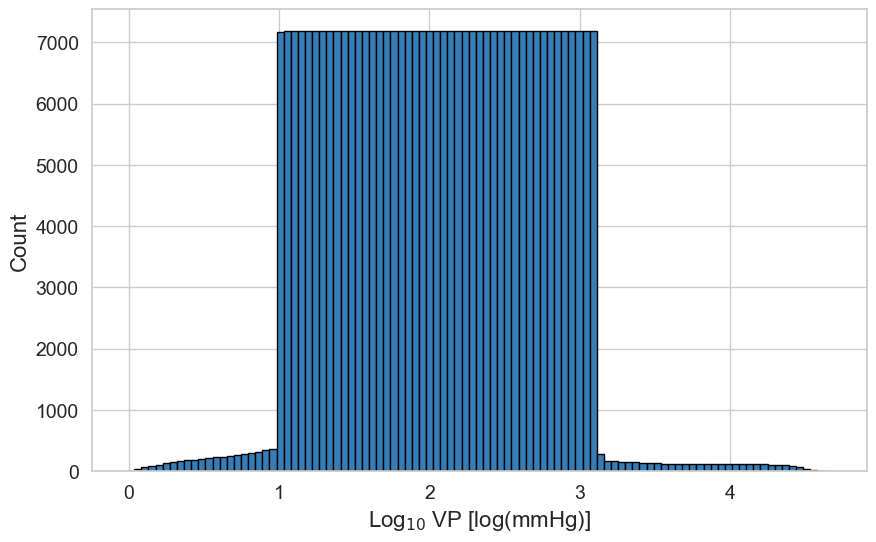

In [174]:
import seaborn as sns

# Apply the seaborn style default as seen in Google Colab
sns.set(style="whitegrid")


# Import Train.xlxs and Test.xlsx as dataframes
train_data = pd.read_excel("Data/Train.xlsx")
test_data = pd.read_excel("Data/Test.xlsx")

# Combine the two dataframes
combined_data = pd.concat([train_data, test_data])

# Extract A, B, C, TMIN, TMAX 
A = combined_data["A"]
B = combined_data["B"]
C = combined_data["C"]
TMIN = combined_data["TMIN"]
TMAX = combined_data["TMAX"]

PMIN = A - B / (TMIN + C)
PMAX = A - B / (TMAX + C)

PMIN = PMIN.to_list()
PMAX = PMAX.to_list()

# Create a list containing all the pressure boundaries for the bins. Each bin will be 1/100 of the total range.
pressure_bins = np.linspace(min(PMIN), max(PMAX), 100)
count = np.zeros(len(pressure_bins) - 1)


# Want to count how many values that are in each bin.
# Iterate over all the compounds
for i in range(len(PMIN)):
    # Itearate over all the bins
    for j in range(len(pressure_bins) - 1):
        # If the pressure value is within the bin, add one to the count for that bin.
        if PMIN[i] <= pressure_bins[j] and PMAX[i] >= pressure_bins[j + 1]:
            count[j] += 1


# Make a bar plot of this distribution
plt.figure(figsize=(10, 6))
plt.bar(pressure_bins[:-1], count, width=pressure_bins[1] - pressure_bins[0], edgecolor='black', color=CB_color_cycle[0])
plt.xlabel("Log$_{10}$ VP [log(mmHg)]", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title("Distribution of pressure values in unfiltered dataset")
plt.show()

This is the distribution after the preprocessing:

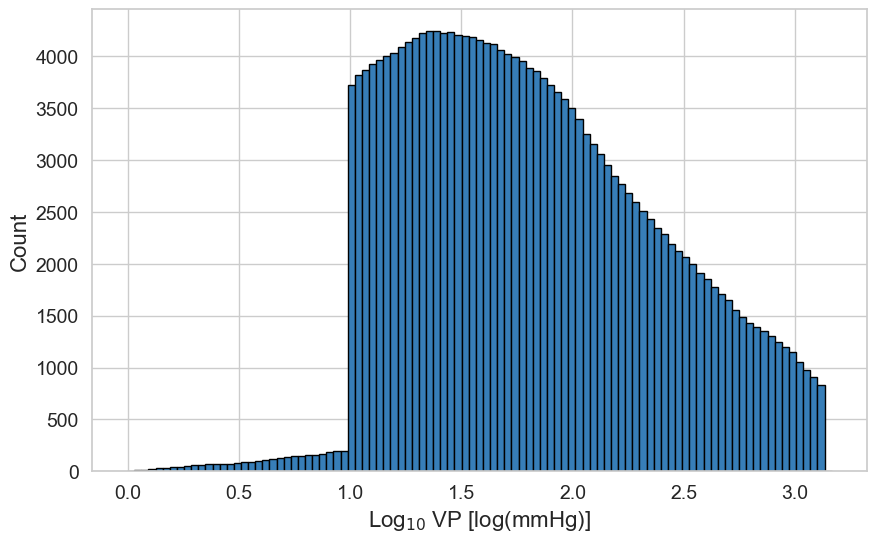

In [175]:

# Import Train.xlxs and Test.xlsx as dataframes. 
train_data = pd.read_excel("Data/Min interval of 20 ºC/7 temperatures/Train.xlsx")
test_data = pd.read_excel("Data/Min interval of 20 ºC/7 temperatures/Test.xlsx")

# Combine the two dataframes
combined_data = pd.concat([train_data, test_data])

# Extract A, B, C, TMIN, TMAX 
A = combined_data["A"]
B = combined_data["B"]
C = combined_data["C"]
TMIN = combined_data["TMIN"]
TMAX = combined_data["TMAX"]

PMIN = A - B / (TMIN + C)
PMAX = A - B / (TMAX + C)

PMIN = PMIN.to_list()
PMAX = PMAX.to_list()

# Create a list containing all the pressure boundaries for the bins. Each bin will be 1/100 of the total range.
pressure_bins = np.linspace(min(PMIN), max(PMAX), 100)
count = np.zeros(len(pressure_bins) - 1)


# Want to count how many values that are in each bin.
# Iterate over all the compounds
for i in range(len(PMIN)):
    # Itearate over all the bins
    for j in range(len(pressure_bins) - 1):
        # If the pressure value is within the bin, add one to the count for that bin.
        if PMIN[i] <= pressure_bins[j] and PMAX[i] >= pressure_bins[j + 1]:
            count[j] += 1


# Make a bar plot of this distribution
plt.figure(figsize=(10, 6))
plt.bar(pressure_bins[:-1], count, width=pressure_bins[1] - pressure_bins[0], edgecolor='black', color=CB_color_cycle[0])
plt.xlabel("Log$_{10}$ VP [log(mmHg)]", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title("Distribution of pressure values in unfiltered dataset")
plt.show()

# Best General Model

Want to illustrate the learning curve of the general model:

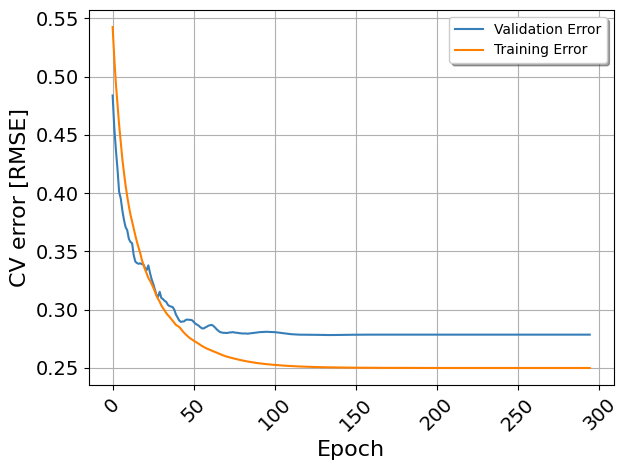

In [176]:
# Set the style back to default 
plt.style.use('default')

# Extracts the cross validation data for the best general model. Remove the first 5 rows as they were noisy. 
df_validation = pd.read_excel(f"Data/Best general model/CV With decay (0.95)/Validation_error.xlsx")[5:]

# Extract the average validation error.
average_validation_error = df_validation["Average"].tolist()

# Want to convert the validation error from MSE to RMSE.
average_validation_error = [val_error ** 0.5 for val_error in average_validation_error]

# Do the same for the training error.   
df_train = pd.read_excel(f"Data/Best general model/CV With decay (0.95)/Train_error.xlsx")[5:]
average_train_error = df_train["Average"].tolist()
average_train_error = [train_error ** 0.5 for train_error in average_train_error]

# Want to plot this to visualize the optimal number of epochs. x-axis is the epoch number and y-axis the validation error.
plt.plot(average_validation_error, label="Validation Error", color=CB_color_cycle[0])
plt.plot(average_train_error, label="Training Error", color=CB_color_cycle[1])
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("CV error [RMSE]", fontsize=16)
#plt.title("Error for each epoch", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Want to rotate the x-axis labels by 90 degrees so they don't overlap
plt.xticks(rotation=45)
# include grids for every 50 epochs
plt.xticks(np.arange(0, len(average_validation_error) + 50, 50))
plt.grid()
plt.legend(shadow=True, fancybox=True, markerscale=1.5)
plt.tight_layout()
plt.show()

Define a function for plotting all the parity plots and KDE plots:

In [149]:
def create_parity_plot(y_hat_values, target_values, temperatures, train_test_val):
    # Plotting the parity line (identity line), that represents a perfect fit. To do this, we need to find the
    # maximum y value (can either be from the actual y value or the predicted value). We also need the minimum value.
    max_val = max(max(y_hat_values), max(target_values))
    min_val = min(min(y_hat_values), min(target_values))

    X_val_list = [-0.5, 3.5]
    y_val_list = [-0.5, 3.5]

    # Create a line between the minimum value and the maximum value. Note that here we have a list of X -values and lis
    plt.figure()
    # Want the x-axis and y-axis numbers to be larger so it becomes easier to read
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # Want to rotate the x-axis labels by 90 degrees so they don't overlap
    plt.xticks(rotation=45)

    plt.xlim(-0.5, 3.5)
    plt.ylim(-0.5, 3.5)

    # Spcify the color of the points based on the temperature.
    temp_colors = []
    target_40_to_70 = []
    target_70_100 = []
    target_100_135 = []
    predicted_40_to_70 = []
    predicted_70_100 = []
    predicted_100_135 = []
    for index, temp in enumerate(temperatures): 
        if temp < 70:
            temp_colors.append(CB_color_cycle[0])
            target_40_to_70.append(target_values[index])
            predicted_40_to_70.append(y_hat_values[index])
        elif temp < 100:
            temp_colors.append(CB_color_cycle[1])
            target_70_100.append(target_values[index])
            predicted_70_100.append(y_hat_values[index])
        else:
            temp_colors.append(CB_color_cycle[2])
            target_100_135.append(target_values[index])
            predicted_100_135.append(y_hat_values[index])

    # Scatter plot of predicted vs. actual values with temperature color coding
    plt.scatter(target_values, y_hat_values, c=temp_colors, alpha=0.9, edgecolors='w', s=40)
    
    plt.plot(X_val_list, y_val_list, 'k--')
    # Have to label the colors manually
    plt.scatter([], [], c=CB_color_cycle[0], label="40°C-70°C", alpha=0.7, edgecolors='w', s=40)
    plt.scatter([], [], c=CB_color_cycle[1], label="70°C-100°C", alpha=0.7, edgecolors='w', s=40)
    plt.scatter([], [], c=CB_color_cycle[2], label="100°C-135°C", alpha=0.7, edgecolors='w', s=40)
    plt.legend(loc='upper left', shadow=True, fancybox=True, markerscale=1.5)

    # Creates title and labels
    plt.xlabel('True', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    #plt.title(f"Parity Plot - {train_test_val}", fontsize=18)
    plt.show()
    plt.close()

    # Also make three individual parity plots for each temperature range.
    plt.figure()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks(rotation=45)
    plt.scatter(target_40_to_70, predicted_40_to_70, c=CB_color_cycle[0], alpha=0.7, edgecolors='w', s=40, label="40°C-70°C")
    plt.plot(X_val_list, y_val_list, 'k--')
    plt.xlabel('True', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    #plt.title(f"Parity Plot - 40°C-70°C - {train_test_val}", fontsize=18)
    plt.legend(loc='upper left', shadow=True, fancybox=True, markerscale=1.5)
    plt.tight_layout()
    plt.show()
    plt.close()

    plt.figure()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks(rotation=45)
    plt.scatter(target_70_100, predicted_70_100, c=CB_color_cycle[1], alpha=0.7, edgecolors='w', s=40, label="70°C-100°C")
    plt.plot(X_val_list, y_val_list, 'k--')
    plt.xlabel('True', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    #plt.title(f"Parity Plot - 70°C-100°C - {train_test_val}", fontsize=18)
    plt.legend(loc='upper left', shadow=True, fancybox=True, markerscale=1.5)
    plt.tight_layout()
    plt.show()
    plt.close()

    plt.figure()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks(rotation=45)
    plt.scatter(target_100_135, predicted_100_135, c=CB_color_cycle[2], alpha=0.7, edgecolors='w', s=40, label="100°C-135°C")
    plt.plot(X_val_list, y_val_list, 'k--')
    plt.xlabel('True', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    #plt.title(f"Parity Plot - 100°C-135°C - {train_test_val}", fontsize=18)
    plt.legend(loc='upper left', shadow=True, fancybox=True, markerscale=1.5)
    plt.tight_layout()
    plt.show()
    plt.close()

In [150]:
def create_kde_plot(y_hat_values, target_values, temperatures, title):
    # Calculate the differences between predicted and actual values
    residuals = [y_hat - y_true for y_hat, y_true in zip(y_hat_values, target_values)]

    # Spcify the color of the points based on the temperature.
    temp_colors = []
    residuals_40_to_70 = []
    residuals_70_100 = []
    residuals_100_135 = []
    for i, temp in enumerate(temperatures): 
        if temp < 70:
            temp_colors.append(CB_color_cycle[0])
            residuals_40_to_70.append(residuals[i])
        elif temp < 100:
            temp_colors.append(CB_color_cycle[1])
            residuals_70_100.append(residuals[i])
        else:
            temp_colors.append(CB_color_cycle[2])
            residuals_100_135.append(residuals[i])

    plt.figure(figsize=(12, 6))
    sns.kdeplot(residuals_40_to_70, shade=True, color=CB_color_cycle[0], bw_adjust=0.8, label="40°C-70°C")
    sns.kdeplot(residuals_70_100, shade=True, color=CB_color_cycle[1], bw_adjust=0.8, label="70°C-100°C")
    sns.kdeplot(residuals_100_135, shade=True, color=CB_color_cycle[2], bw_adjust=0.8, label="100°C-135°C")
    #sns.kdeplot(y_hat_values, shade=True, color="r", bw_adjust=0.2)
    #sns.kdeplot(target_values, shade=True, color="b", bw_adjust=0.2)
    #plt.title(f'KDE of LogVP - {title}', fontsize=18)
    plt.xlabel('Residuals (Predicted - True)', fontsize=20)
    plt.ylabel('Density', fontsize=20)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(-2, 2)
    plt.legend(loc='upper left', shadow=True, fancybox=True, markerscale=1.5, fontsize=18)
    plt.tight_layout()
    plt.show()
    plt.close()

    plt.figure(figsize=(12, 6))
    #sns.kdeplot(y_hat_values, shade=True, color="r", bw_adjust=0.2)
    sns.kdeplot(residuals, shade=True, color=CB_color_cycle[0], bw_adjust=0.8)
    #plt.title(f'KDE of LogVP - {title}', fontsize=18)
    plt.xlabel('Residuals (Predicted - True)', fontsize=20)
    plt.ylabel('Density', fontsize=20)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.legend(loc='upper left', shadow=True, fancybox=True, markerscale=1.5)
    plt.tight_layout()

    # Calculate the 95% confidence interval
    lower_bound = np.percentile(residuals, 5)
    upper_bound = np.percentile(residuals, 95)

    plt.xlim(-2, 2)

    # Annotate the 95% confidence interval on the plot
    plt.axvline(lower_bound, color='black', linestyle='--', linewidth=1.5, label=f'5th percentile: {lower_bound:.2f}')
    plt.axvline(upper_bound, color='black', linestyle='--', linewidth=1.5, label=f'95th percentile: {upper_bound:.2f}')
    plt.legend(loc='upper left', shadow=True, fancybox=True, markerscale=1.5, fontsize=18)
    plt.show()
    plt.close()

Also want to define a function that plots the actual distribution of the data. See report for more information. 

In [151]:
def create_dist_plot(data, temperature_train, title):
    # Create distribution plot for data
    plt.figure(figsize=(12, 6))
    sns.histplot(data, bins=100, color=CB_color_cycle[0])
    #plt.title(f'Distribution of LogVP - {title}', fontsize=18)
    plt.xlabel("Log$_{10}$ VP [log(mmHg)]", fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper left', shadow=True, fancybox=True, markerscale=1.5)
    plt.tight_layout()
    plt.show()
    

Create the parity and KDE plots for the general model. Note that here, excel files containing the predictions was used instead of running the model again.


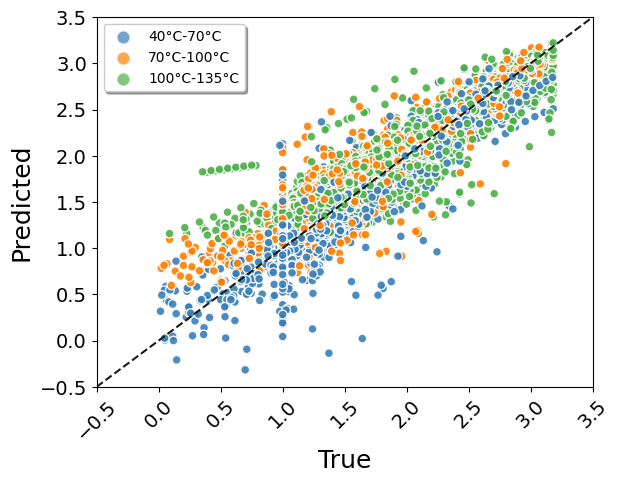

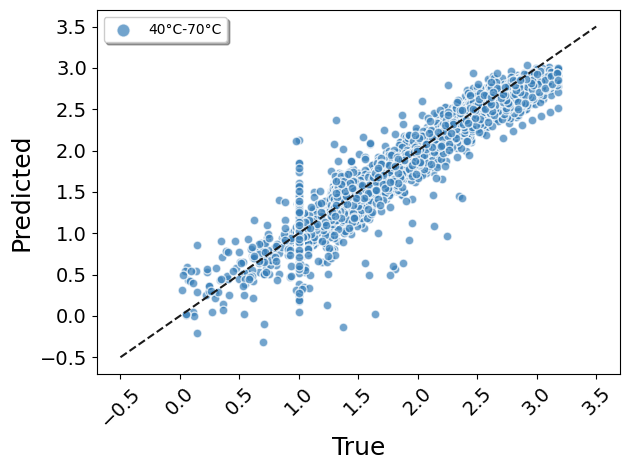

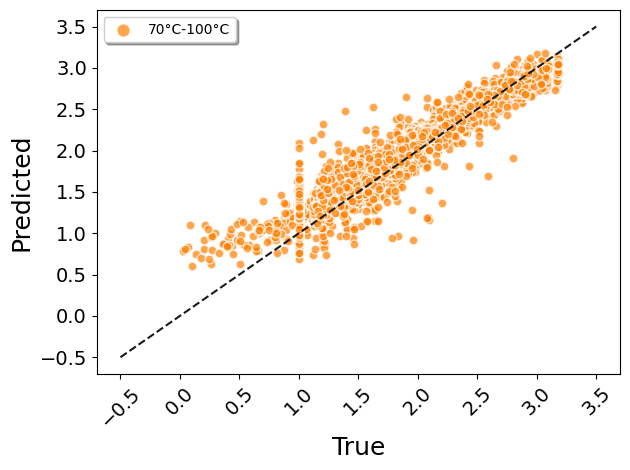

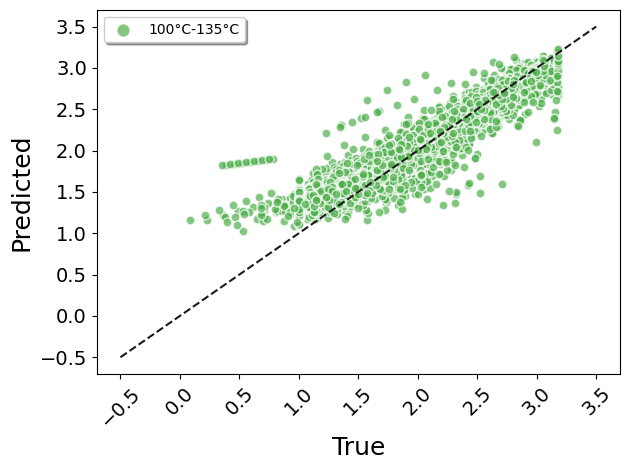

/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/4029554638.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals_40_to_70, shade=True, color=CB_color_cycle[0], bw_adjust=0.8, label="40°C-70°C")
/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/4029554638.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals_70_100, shade=True, color=CB_color_cycle[1], bw_adjust=0.8, label="70°C-100°C")
/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/4029554638.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals_100_135, shade=True, color=CB_color_cycle[2], bw_adju

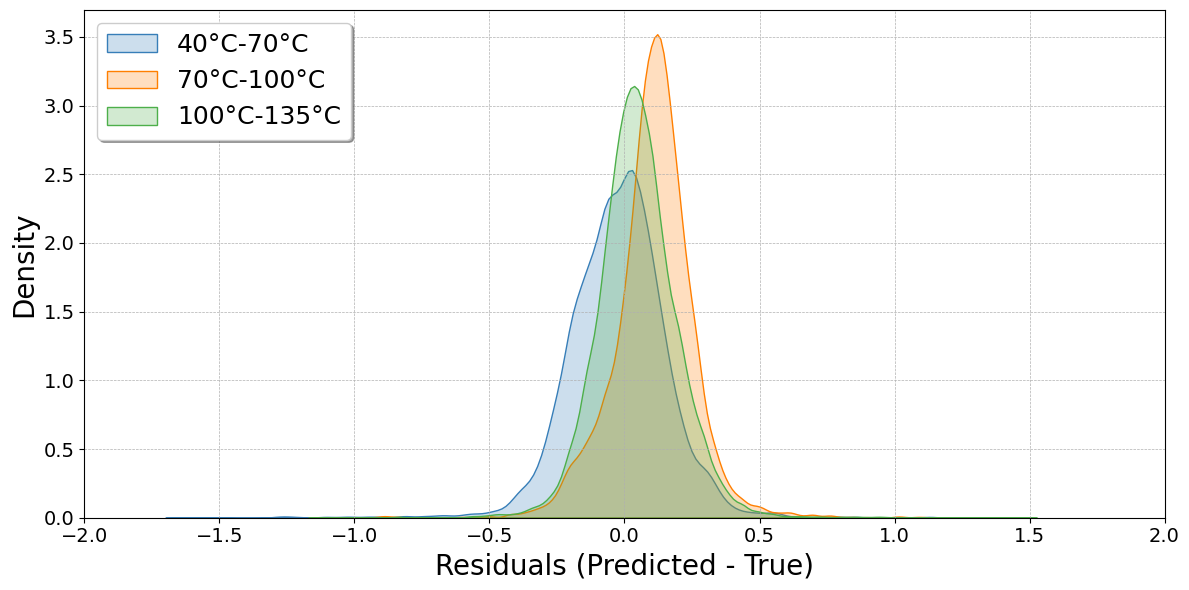

/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/4029554638.py:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True, color=CB_color_cycle[0], bw_adjust=0.8)


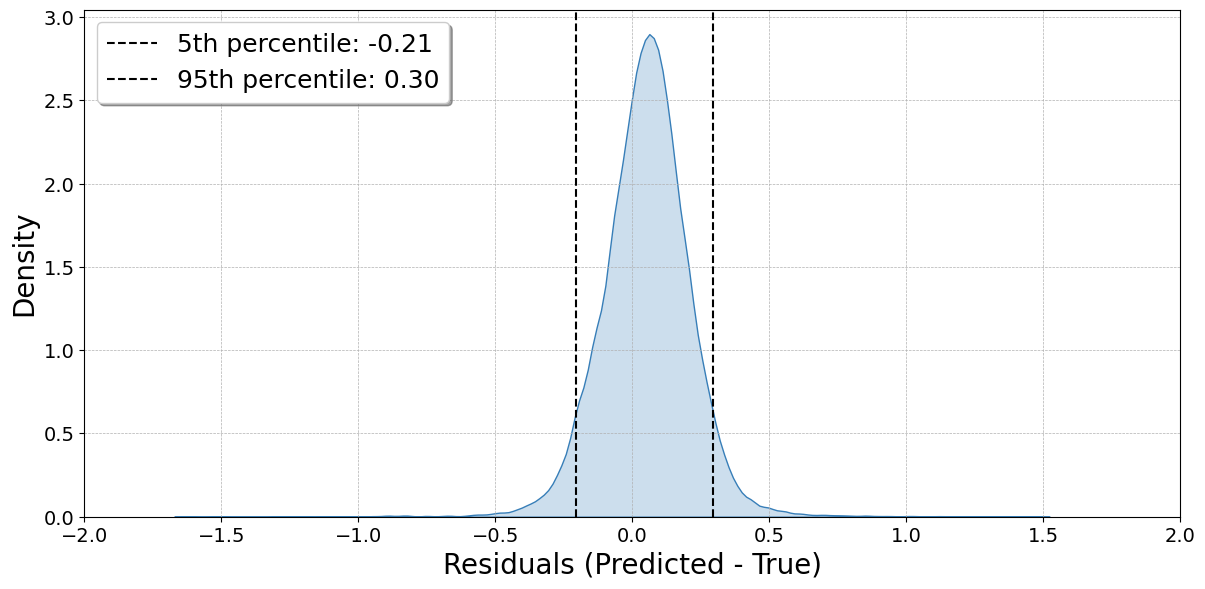

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


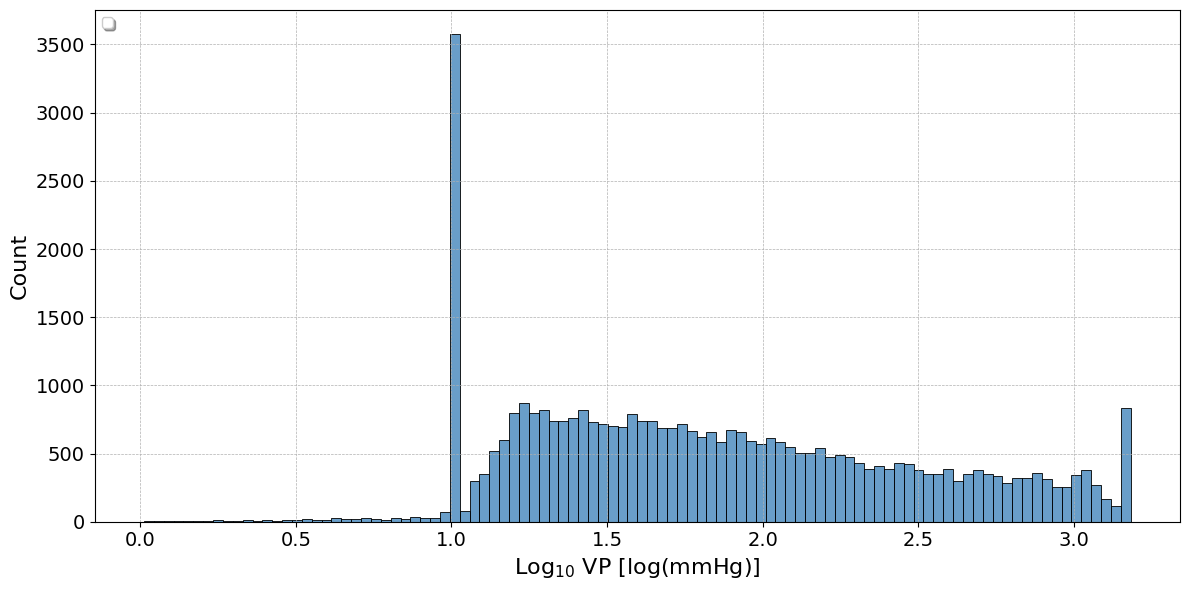

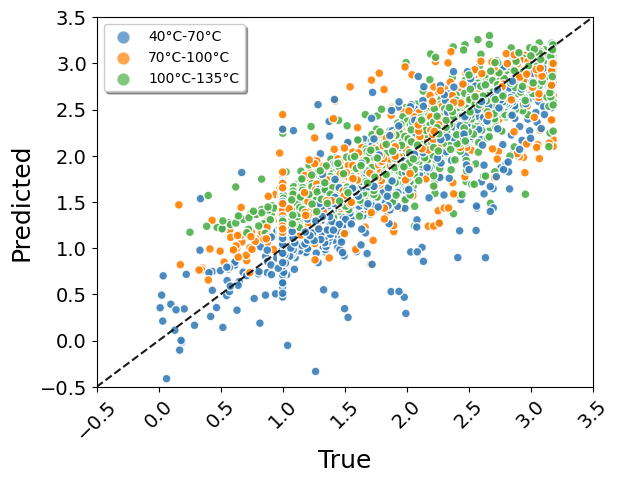

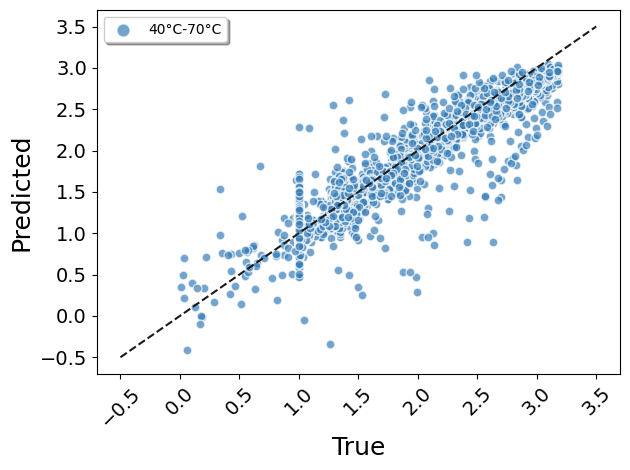

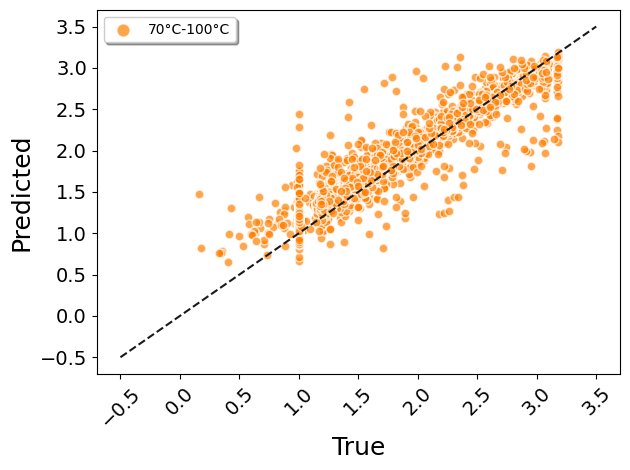

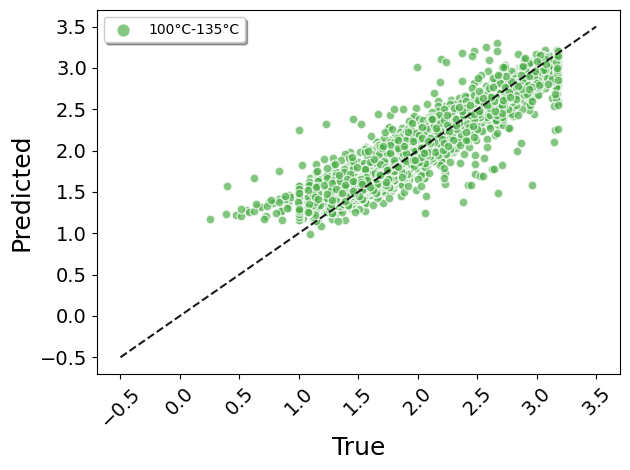

/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/4029554638.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals_40_to_70, shade=True, color=CB_color_cycle[0], bw_adjust=0.8, label="40°C-70°C")
/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/4029554638.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals_70_100, shade=True, color=CB_color_cycle[1], bw_adjust=0.8, label="70°C-100°C")
/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/4029554638.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals_100_135, shade=True, color=CB_color_cycle[2], bw_adju

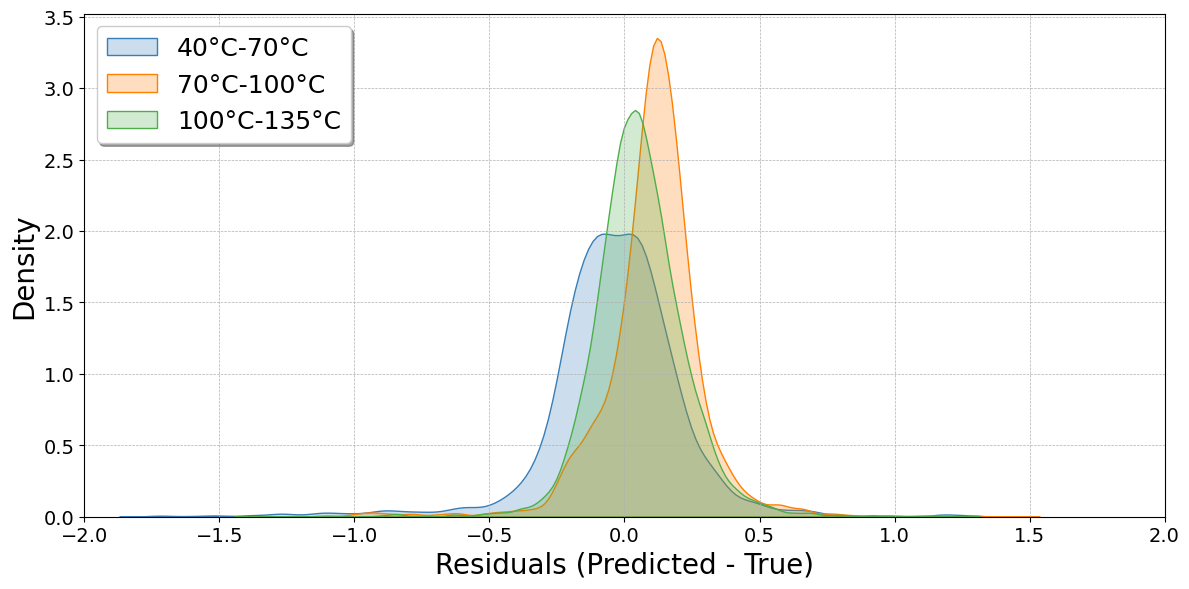

/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/4029554638.py:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True, color=CB_color_cycle[0], bw_adjust=0.8)


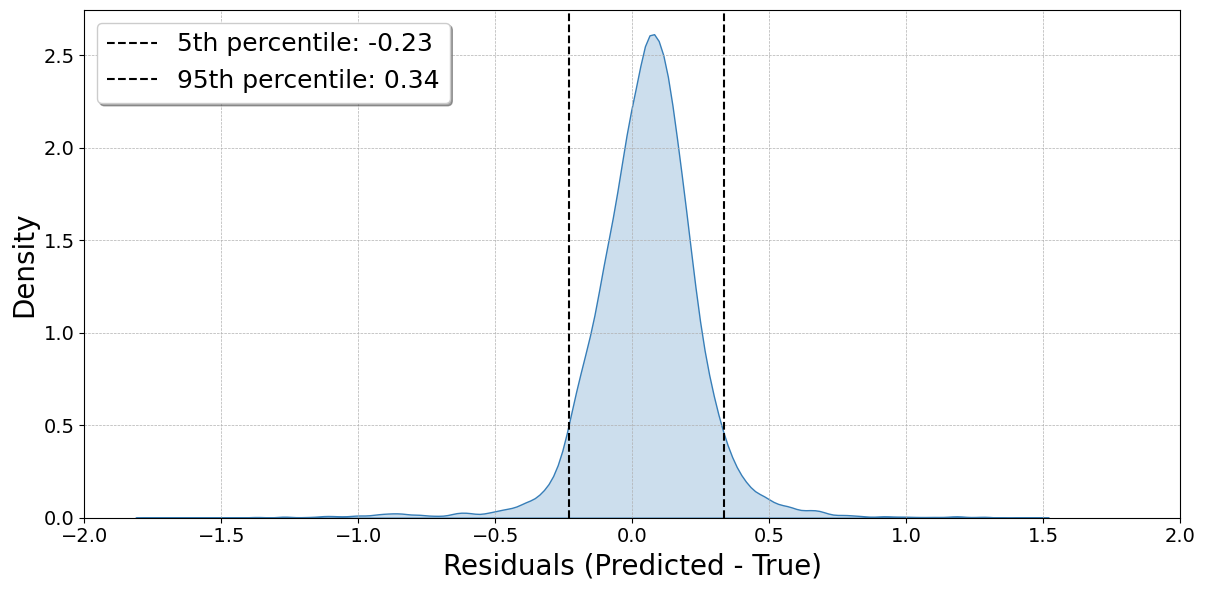

Amount of training data with temperature between 40°C and 70°C: 7370
Amount of training data with temperature between 70°C and 100°C: 11272
Amount of training data with temperature between 100°C and 135°C: 20425
Amount of training data with temperature between 40°C and 70°C and log(P) < 1: 206
Amount of training data with temperature between 70°C and 100°C and log(P) < 1: 148
Amount of training data with temperature between 100°C and 135°C and log(P) < 1: 105
Percentage of training data with temperature between 40°C and 70°C and log(P) < 1: 2.795115332428765
Percentage of training data with temperature between 70°C and 100°C and log(P) < 1: 1.312987934705465
Percentage of training data with temperature between 100°C and 135°C and log(P) < 1: 0.5140758873929009
Amount of training data with temperature between 40°C and 70°C and log(P) at 1 log(mmHg): 1453
Amount of training data with temperature between 70°C and 100°C and log(P) at 1 log(mmHg): 1691
Amount of training data with temperatu

In [177]:
df_train = pd.read_excel(f"Data/Best general model/Predicted_values_train.xlsx")
df_test = pd.read_excel(f"Data/Best general model/Predicted_values_test.xlsx")

# Extract data from the columns Temperature, Predicted log(P) and Actual log(P) for the training and test data.
temperature_train = df_train["Temperature"].tolist()
y_hat_values_train = df_train["Predicted log(P)"].tolist()
target_values_train = df_train["Actual log(P)"].tolist()

temperature_test = df_test["Temperature"].tolist()
y_hat_values_test = df_test["Predicted log(P)"].tolist()
target_values_test = df_test["Actual log(P)"].tolist()


# Create a parity plot and kernel density esimation plot for training data. 
create_parity_plot(y_hat_values_train, target_values_train, temperature_train, "Train")
create_kde_plot(y_hat_values_train, target_values_train, temperature_train, "Train")


# Create plot for the total pressure data.
total_data = target_values_train + target_values_test
create_dist_plot(total_data, temperature_train, "Train")


# Create a parity plot and kernel density esimation plot for test data.
create_parity_plot(y_hat_values_test, target_values_test, temperature_test, "Test")
create_kde_plot(y_hat_values_test, target_values_test, temperature_test, "Test")

# Print out amount of data with different temperatures.
amount_40_to_70 = len([temp for temp in temperature_train if temp < 70]) + len([temp for temp in temperature_test if temp < 70])
amount_70_to_100 = len([temp for temp in temperature_train if temp < 100 and temp >= 70]) + len([temp for temp in temperature_test if temp < 100 and temp >= 70])
amount_100_to_135 = len([temp for temp in temperature_train if temp >= 100]) + len([temp for temp in temperature_test if temp >= 100])
print(f"Amount of training data with temperature between 40°C and 70°C: {amount_40_to_70}")
print(f"Amount of training data with temperature between 70°C and 100°C: {amount_70_to_100}")
print(f"Amount of training data with temperature between 100°C and 135°C: {amount_100_to_135}")

# Print the amount of data with log(P) values below 1 for each temperature range.
amount_40_to_70_low_pres = len([logP for logP, temp in zip(target_values_train, temperature_train) if temp < 70 and logP < 0.98]) + len([logP for logP, temp in zip(target_values_test, temperature_test) if temp < 70 and logP < 0.98])
amount_70_to_100_low_pres = len([logP for logP, temp in zip(target_values_train, temperature_train) if temp < 100 and temp >= 70 and logP < 0.98]) + len([logP for logP, temp in zip(target_values_test, temperature_test) if temp < 100 and temp >= 70 and logP < 0.98])
amount_100_to_135_low_pres = len([logP for logP, temp in zip(target_values_train, temperature_train) if temp >= 100 and logP < 0.98]) + len([logP for logP, temp in zip(target_values_test, temperature_test) if temp >= 100 and logP < 0.98])
print(f"Amount of training data with temperature between 40°C and 70°C and log(P) < 1: {amount_40_to_70_low_pres}")
print(f"Amount of training data with temperature between 70°C and 100°C and log(P) < 1: {amount_70_to_100_low_pres}")
print(f"Amount of training data with temperature between 100°C and 135°C and log(P) < 1: {amount_100_to_135_low_pres}")

# Calculate the percentage of data with log(P) values below 1 for each temperature range.
percentage_40_to_70_low_pres = amount_40_to_70_low_pres / amount_40_to_70 * 100
percentage_70_to_100_low_pres = amount_70_to_100_low_pres / amount_70_to_100 * 100
percentage_100_to_135_low_pres = amount_100_to_135_low_pres / amount_100_to_135 * 100
print(f"Percentage of training data with temperature between 40°C and 70°C and log(P) < 1: {percentage_40_to_70_low_pres}")
print(f"Percentage of training data with temperature between 70°C and 100°C and log(P) < 1: {percentage_70_to_100_low_pres}")
print(f"Percentage of training data with temperature between 100°C and 135°C and log(P) < 1: {percentage_100_to_135_low_pres}")

# Print out the amount of data that is in the range 0.97 to 1.03 regarding the pressure for all temperature ranges.
amount_40_to_70_pres = len([logP for logP, temp in zip(target_values_train, temperature_train) if temp < 70 and logP >= 0.97 and logP <= 1.03]) + len([logP for logP, temp in zip(target_values_test, temperature_test) if temp < 70 and logP >= 0.97 and logP <= 1.03])
amount_70_to_100_pres = len([logP for logP, temp in zip(target_values_train, temperature_train) if temp < 100 and temp >= 70 and logP >= 0.97 and logP <= 1.03]) + len([logP for logP, temp in zip(target_values_test, temperature_test) if temp < 100 and temp >= 70 and logP >= 0.97 and logP <= 1.03])
amount_100_to_135_pres = len([logP for logP, temp in zip(target_values_train, temperature_train) if temp >= 100 and logP >= 0.97 and logP <= 1.03]) + len([logP for logP, temp in zip(target_values_test, temperature_test) if temp >= 100 and logP >= 0.97 and logP <= 1.03])
print(f"Amount of training data with temperature between 40°C and 70°C and log(P) at 1 log(mmHg): {amount_40_to_70_pres}")
print(f"Amount of training data with temperature between 70°C and 100°C and log(P) at 1 log(mmHg): {amount_70_to_100_pres}") 
print(f"Amount of training data with temperature between 100°C and 135°C and log(P) at 1 log(mmHg): {amount_100_to_135_pres}")

In the code below, the general model interpolates and gives the Antoine coefficents for the compounds of interest. 

CNCCNC
[4.273001670837402] [213.2699432373047] [38.333763122558594]


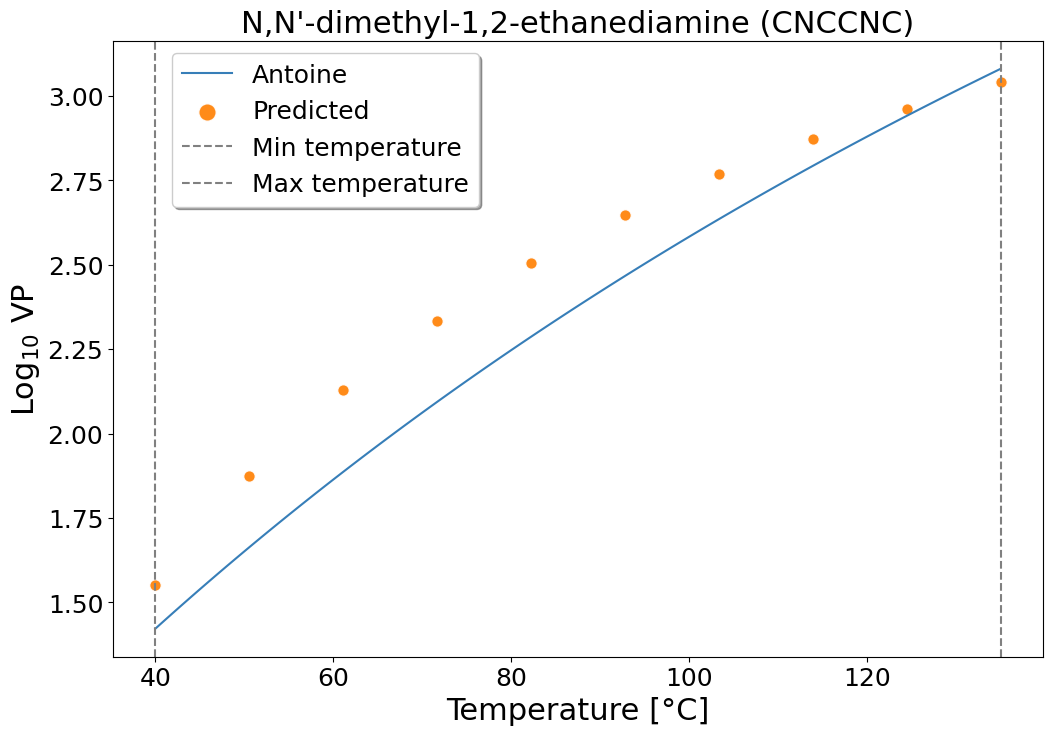

CCN(CC)CCN
[4.170289039611816] [286.62347412109375] [47.76661682128906]


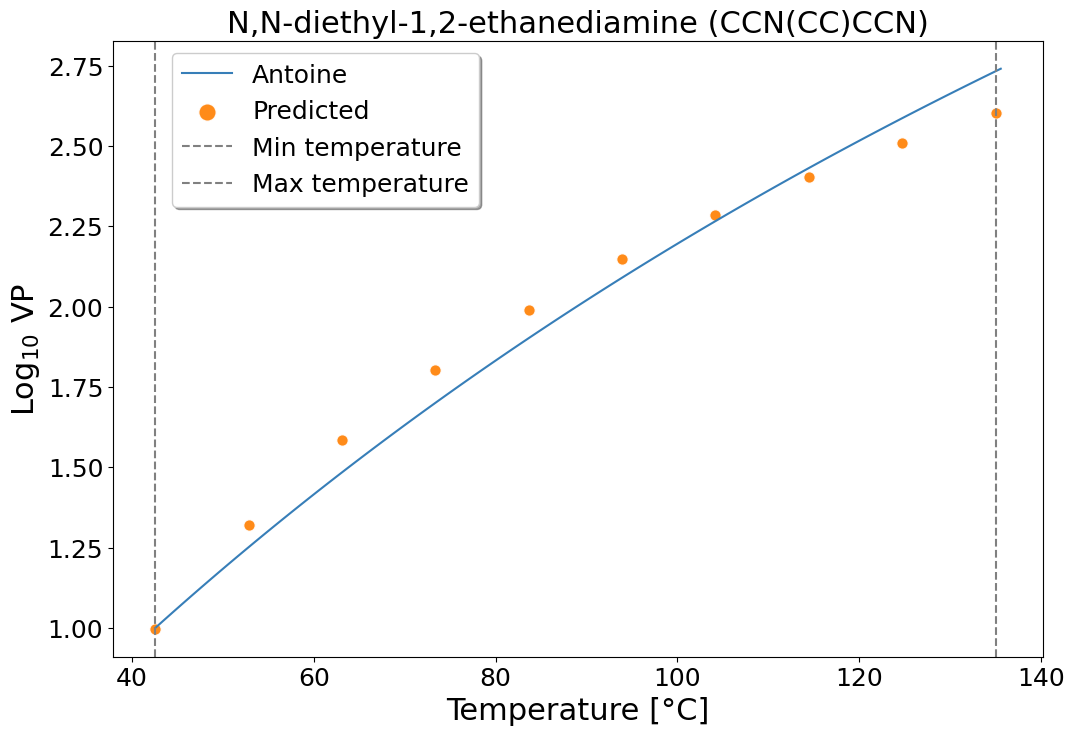

CCCN(CCC)CCO
[3.4594993591308594] [287.38372802734375] [33.022071838378906]


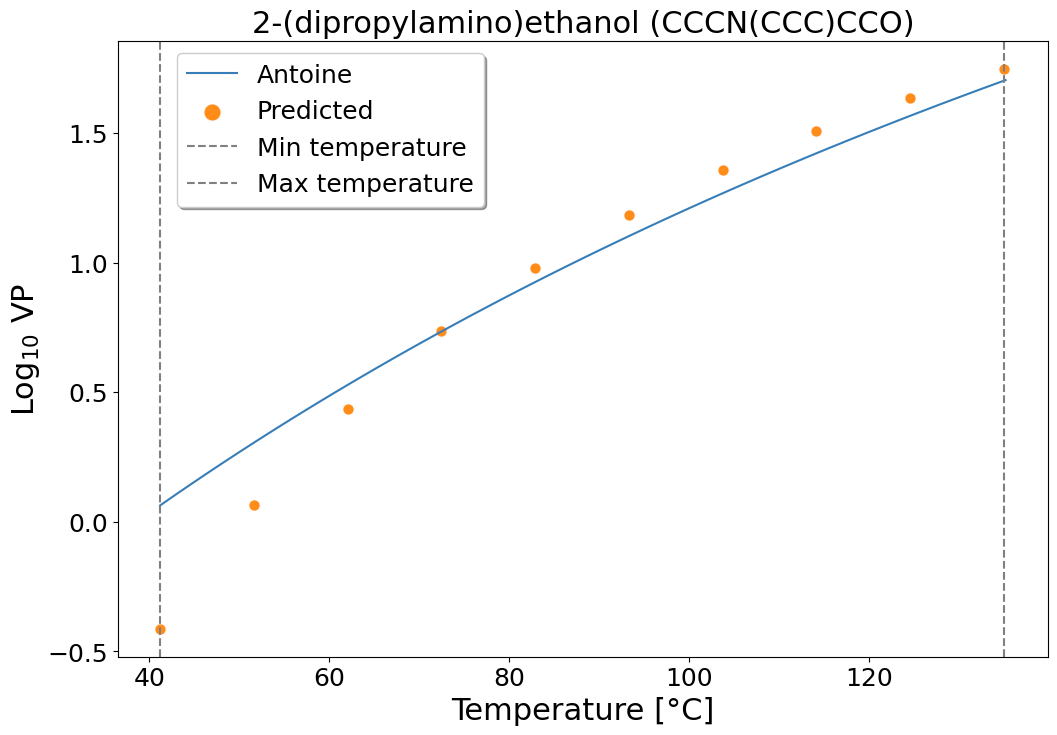

In [179]:
# Iterate over all the test data, and calculate Predicted log(P) - Actual log(P) for each molecule. 
df_test_predicted = pd.read_excel(f"Data/Min interval of 20 ºC/7 temperatures/Test.xlsx")

# Need to extract the antonine data for the molecules to compare. 
df_test_with_antonine = pd.read_excel(f"Data/Test.xlsx")

# Iterates over all the molecules in the test data.
for index, smiles in enumerate(df_test_predicted["SMILES"].unique()):

    # Want to plot the predicted and true values for the following molecules. 
    if smiles == "CCCN(CCC)CCO" or smiles == "CCN(CC)CCN" or smiles== "CNCCNC":

        # For extracting the antonine data
        df_antonine_one_molecule = df_test_with_antonine[df_test_with_antonine["SMILES"] == smiles]

        # Get the lowest and highest temperature for the molecule (will have the model extrapolate).
        # Minimum temperature should be minimum or 40, depending on which is the highest. 
        min_temp = df_antonine_one_molecule["TMIN"].item()
        max_temp = df_antonine_one_molecule["TMAX"].item()

        # Remove this for extrapolation.
        trained_on_min = min_temp
        trained_on_max = max_temp
        if min_temp < 40:
            trained_on_min = 40

        if max_temp > 135: 
            trained_on_max = 135

        # Generate a temperature range for the molecule.
        temperature_range = np.arange(trained_on_min, trained_on_max + 1, 1)

        # Calculates the true values for the amine in the whole range of temperatures.
        A = df_antonine_one_molecule["A"].item()
        B = df_antonine_one_molecule["B"].item()
        C = df_antonine_one_molecule["C"].item()
        pressure_true = []
        for temp in temperature_range:
            log_P = A - B / (temp + C)
            pressure_true.append(log_P)

        #print(f"True A, B, C: {A}, {B}, {C}")
        # Extract 10 uniformly distrubuted temperatures between the min and max temperature.
        temperature_range_10_points = np.linspace(trained_on_min, trained_on_max, 10)
        print(smiles)
        # Calculate the predicted values for the molecule in the whole range of temperatures.
        pressure_predicted = []
        A_pred, B_pred, C_pred = 0, 0, 0
        for temp in temperature_range_10_points:
            pressure, A_pred, B_pred, C_pred = model_prediction_general([smiles], [temp])
            if pressure_predicted == []:
                print(A_pred, B_pred, C_pred)
            pressure_predicted.append(pressure[0])

        # If extrapolation folder does not exist, create it.
        if not os.path.exists("Data/Final model/Interpolation"):
            os.makedirs("Data/Final model/Interpolation")
            
        name = df_test_with_antonine[df_test_with_antonine["SMILES"] == smiles]["NAME"].item()
        # Capitalize the first letter
        name = name[0].upper() + name[1:]

        # Want to make figure larger
        plt.figure(figsize=(12,8)) 

        plt.plot(temperature_range, pressure_true, label="Antoine",  color=CB_color_cycle[0])
        # Add points as x
        plt.scatter(temperature_range_10_points, pressure_predicted, c=CB_color_cycle[1], alpha=0.9, edgecolors='w', s=70, label="Predicted")
        # Plot straight lines for the min and max temperature.
        plt.axvline(x=trained_on_min, color="gray", linestyle="--", label="Min temperature")
        plt.axvline(x=trained_on_max, color="gray", linestyle="--", label="Max temperature")
        plt.xlabel("Temperature [°C]", fontsize=22)
        plt.ylabel("Log$_{10}$ VP", fontsize=22)
        #plt.ylim(2,4)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.title(f"{name} ({smiles})", fontsize=22)
        plt.legend(loc='upper left', bbox_to_anchor=(0.05, 1), shadow=True, fancybox=True, markerscale=1.5, fontsize=18)
        plt.show()
        #plt.savefig(f"Data/Final model/Interpolation/{smiles}.png")
        plt.close()

# Specialized amine model

Will now move on to prucing the plots for the specialized amine model. Will produce the same plots as for the general model. Will also plot how the model extrapolates.

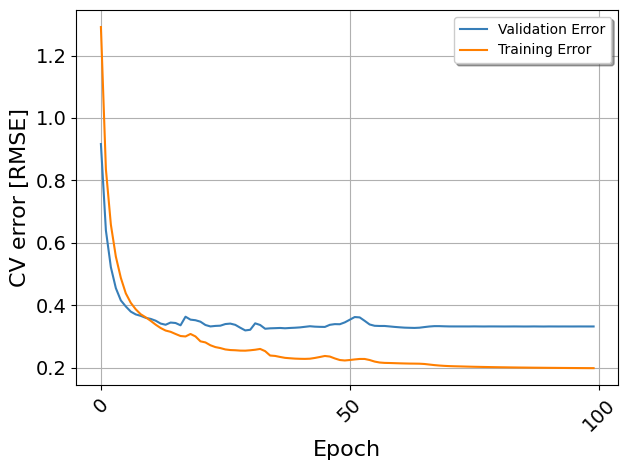

In [43]:
# Extracts the cross validation data for the best general model.
df_validation = pd.read_excel(f"Data/Best amine model/CV/Validation_error.xlsx")

# Extract the average validation error.
average_validation_error = df_validation["Average"].tolist()

# Want to convert the validation error from MSE to RMSE.
average_validation_error = [val_error ** 0.5 for val_error in average_validation_error]

# Do the same for the training error.   
df_train = pd.read_excel(f"Data/Best amine model/CV/Train_error.xlsx")
average_train_error = df_train["Average"].tolist()
average_train_error = [train_error ** 0.5 for train_error in average_train_error]

# Want to plot this to visualize the optimal number of epochs. x-axis is the epoch number and y-axis the validation error.
plt.plot(average_validation_error, label="Validation Error", color=CB_color_cycle[0])
plt.plot(average_train_error, label="Training Error", color=CB_color_cycle[1])
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("CV error [RMSE]", fontsize=16)
#plt.title("Error for each epoch", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Want to rotate the x-axis labels by 90 degrees so they don't overlap
plt.xticks(rotation=45)
# include grids for every 50 epochs
plt.xticks(np.arange(0, len(average_validation_error) + 50, 50))
plt.grid()
plt.legend(shadow=True, fancybox=True, markerscale=1.5)
plt.tight_layout()
plt.show()

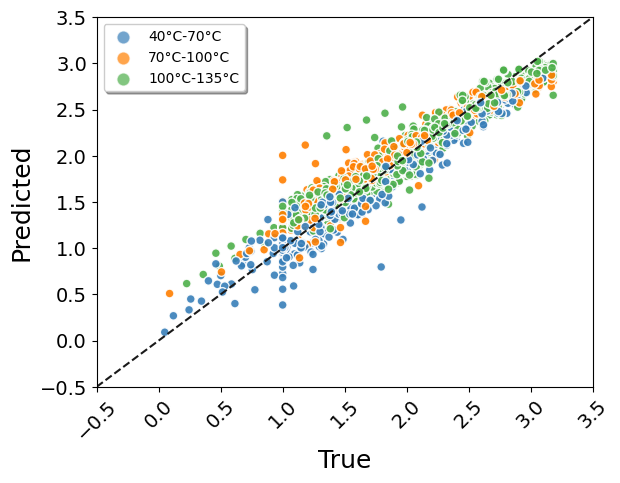

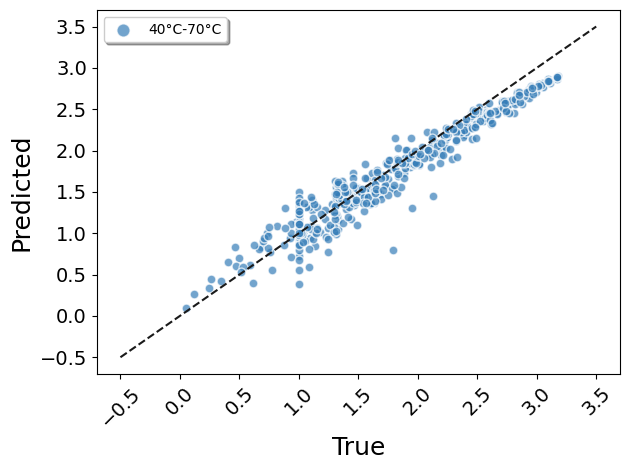

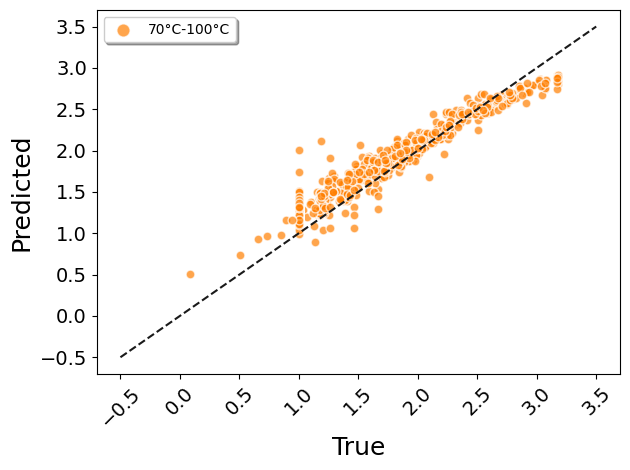

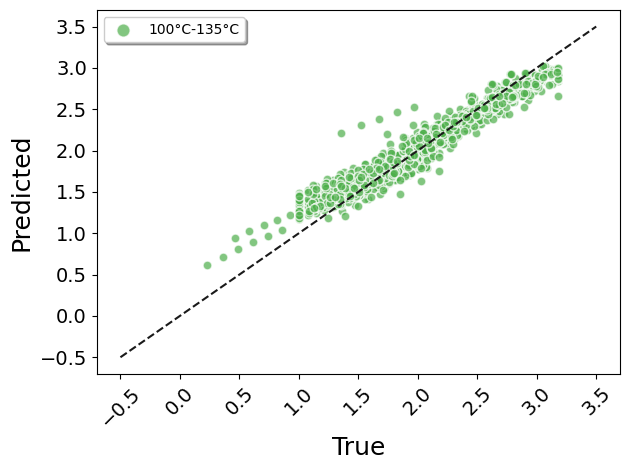

/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/4029554638.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals_40_to_70, shade=True, color=CB_color_cycle[0], bw_adjust=0.8, label="40°C-70°C")
/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/4029554638.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals_70_100, shade=True, color=CB_color_cycle[1], bw_adjust=0.8, label="70°C-100°C")
/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/4029554638.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals_100_135, shade=True, color=CB_color_cycle[2], bw_adju

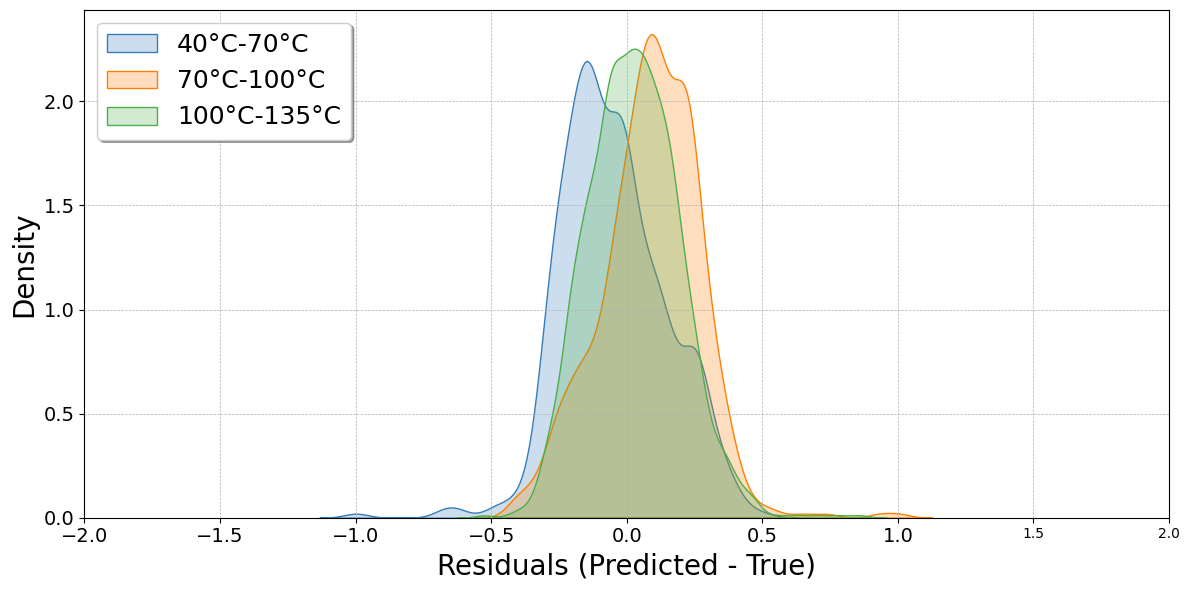

/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/4029554638.py:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True, color=CB_color_cycle[0], bw_adjust=0.8)


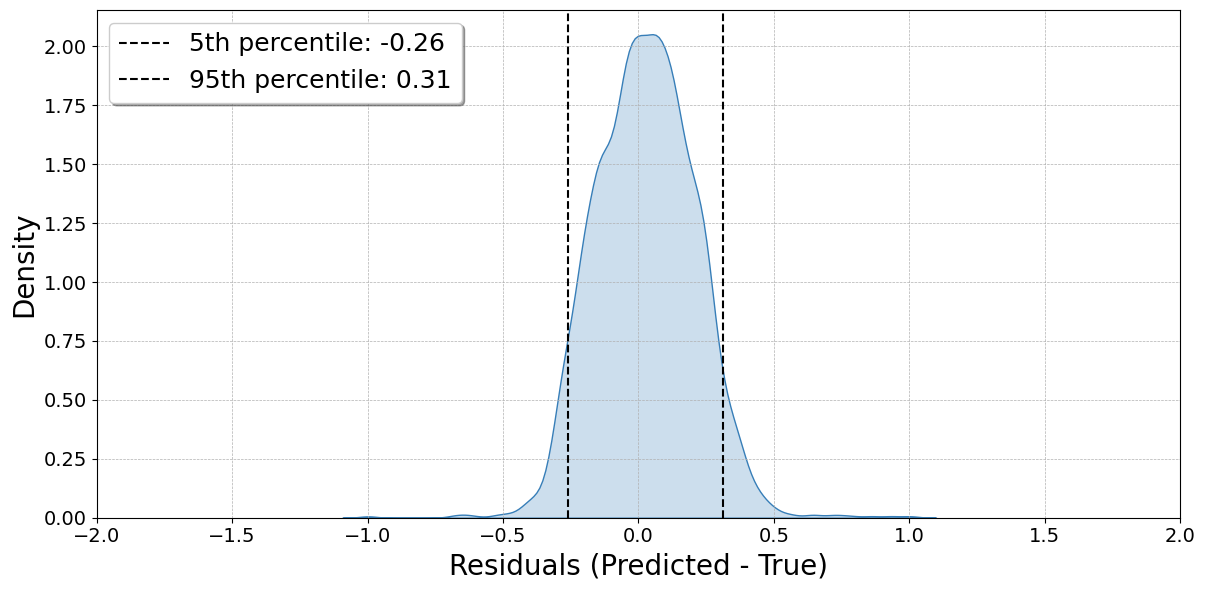

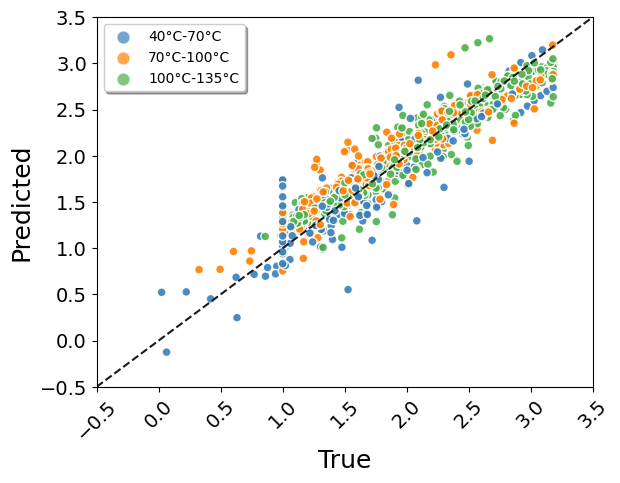

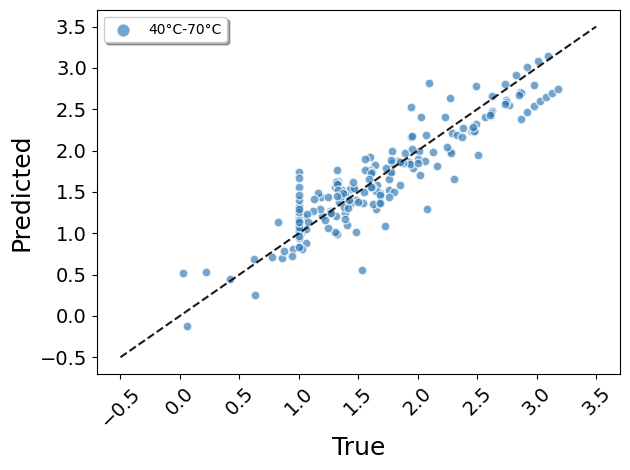

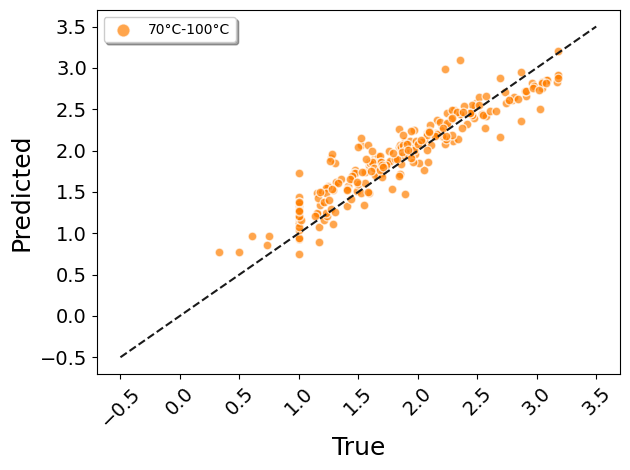

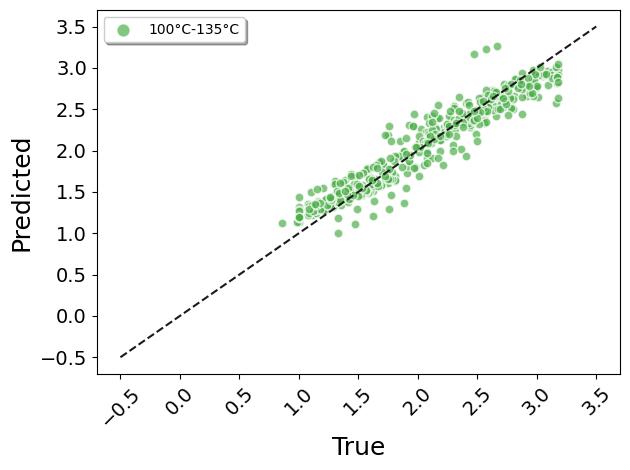

/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/4029554638.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals_40_to_70, shade=True, color=CB_color_cycle[0], bw_adjust=0.8, label="40°C-70°C")
/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/4029554638.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals_70_100, shade=True, color=CB_color_cycle[1], bw_adjust=0.8, label="70°C-100°C")
/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/4029554638.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals_100_135, shade=True, color=CB_color_cycle[2], bw_adju

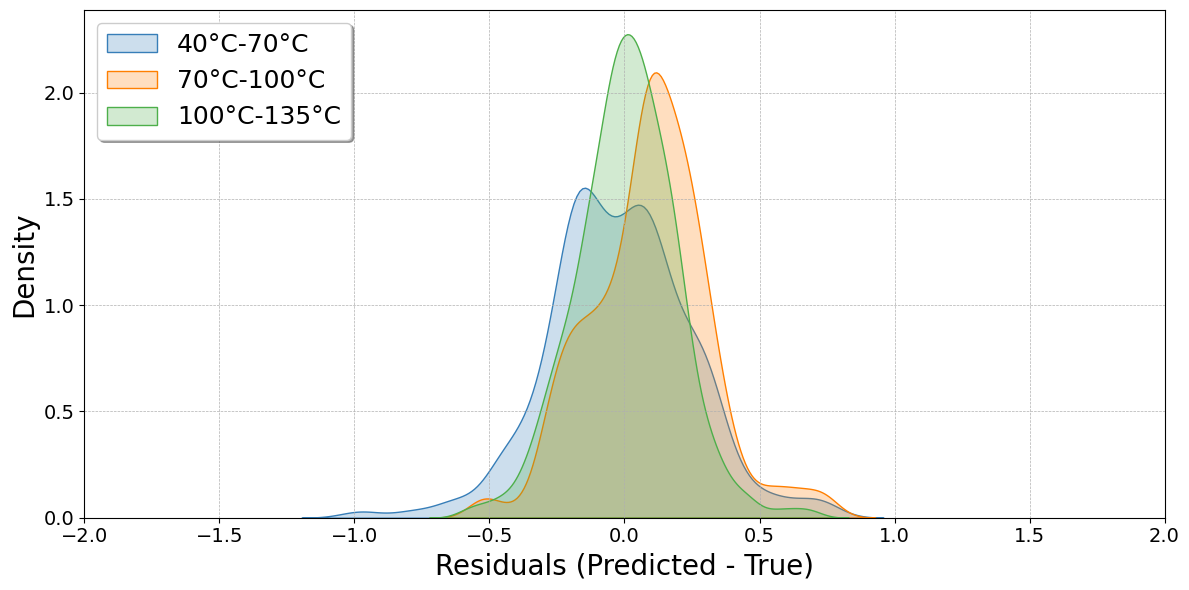

/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/4029554638.py:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True, color=CB_color_cycle[0], bw_adjust=0.8)


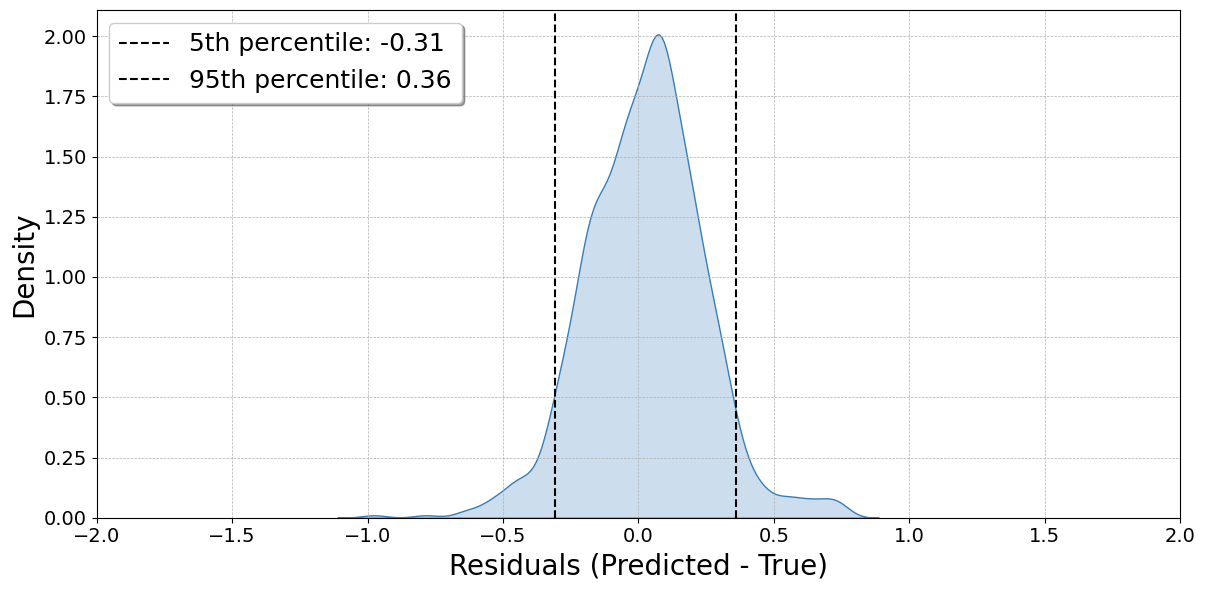

Amount of training data with temperature between 40°C and 70°C: 650
Amount of training data with temperature between 70°C and 100°C: 828
Amount of trainin>g data with temperature between 100°C and 135°C: 1539
Amount of training data with temperature between 40°C and 70°C and log(P) < 1: 45
Amount of training data with temperature between 70°C and 100°C and log(P) < 1: 12
Amount of training data with temperature between 100°C and 135°C and log(P) < 1: 12
Percentage of training data with temperature between 40°C and 70°C and log(P) < 1: 6.923076923076923
Percentage of training data with temperature between 70°C and 100°C and log(P) < 1: 1.4492753623188406
Percentage of training data with temperature between 100°C and 135°C and log(P) < 1: 0.7797270955165692


In [153]:
df_train = pd.read_excel(f"Data/Best amine model/Predicted_values_train.xlsx")
df_test = pd.read_excel(f"Data/Best amine model/Predicted_values_test.xlsx")

# Extract data from the columns Temperature, Predicted log(P) and Actual log(P) for the training and test data.
temperature_train = df_train["Temperature"].tolist()
y_hat_values_train = df_train["Predicted log(P)"].tolist()
target_values_train = df_train["Actual log(P)"].tolist()

temperature_test = df_test["Temperature"].tolist()
y_hat_values_test = df_test["Predicted log(P)"].tolist()
target_values_test = df_test["Actual log(P)"].tolist()


# Create a parity plot and kernel density esimation plot for training data. 
create_parity_plot(y_hat_values_train, target_values_train, temperature_train, "Train")
create_kde_plot(y_hat_values_train, target_values_train, temperature_train, "Train")
#create_dist_plot(y_hat_values_train, target_values_train, temperature_train, "Train")

# Create a parity plot and kernel density esimation plot for test data.
create_parity_plot(y_hat_values_test, target_values_test, temperature_test, "Test")
create_kde_plot(y_hat_values_test, target_values_test, temperature_test, "Test")

# Print out amount of data with different temperatures.
amount_40_to_70 = len([temp for temp in temperature_train if temp < 70]) + len([temp for temp in temperature_test if temp < 70])
amount_70_to_100 = len([temp for temp in temperature_train if temp < 100 and temp >= 70]) + len([temp for temp in temperature_test if temp < 100 and temp >= 70])
amount_100_to_135 = len([temp for temp in temperature_train if temp >= 100]) + len([temp for temp in temperature_test if temp >= 100])
print(f"Amount of training data with temperature between 40°C and 70°C: {amount_40_to_70}")
print(f"Amount of training data with temperature between 70°C and 100°C: {amount_70_to_100}")
print(f"Amount of trainin>g data with temperature between 100°C and 135°C: {amount_100_to_135}")

# Print the amount of data with log(P) values below 1 for each temperature range.
amount_40_to_70_low_pres = len([logP for logP, temp in zip(target_values_train, temperature_train) if temp < 70 and logP < 0.98]) + len([logP for logP, temp in zip(target_values_test, temperature_test) if temp < 70 and logP < 0.98])
amount_70_to_100_low_pres = len([logP for logP, temp in zip(target_values_train, temperature_train) if temp < 100 and temp >= 70 and logP < 0.98]) + len([logP for logP, temp in zip(target_values_test, temperature_test) if temp < 100 and temp >= 70 and logP < 0.98])
amount_100_to_135_low_pres = len([logP for logP, temp in zip(target_values_train, temperature_train) if temp >= 100 and logP < 0.98]) + len([logP for logP, temp in zip(target_values_test, temperature_test) if temp >= 100 and logP < 0.98])
print(f"Amount of training data with temperature between 40°C and 70°C and log(P) < 1: {amount_40_to_70_low_pres}")
print(f"Amount of training data with temperature between 70°C and 100°C and log(P) < 1: {amount_70_to_100_low_pres}")
print(f"Amount of training data with temperature between 100°C and 135°C and log(P) < 1: {amount_100_to_135_low_pres}")

# Calculate the percentage of data with log(P) values below 1 for each temperature range.
percentage_40_to_70_low_pres = amount_40_to_70_low_pres / amount_40_to_70 * 100
percentage_70_to_100_low_pres = amount_70_to_100_low_pres / amount_70_to_100 * 100
percentage_100_to_135_low_pres = amount_100_to_135_low_pres / amount_100_to_135 * 100
print(f"Percentage of training data with temperature between 40°C and 70°C and log(P) < 1: {percentage_40_to_70_low_pres}")
print(f"Percentage of training data with temperature between 70°C and 100°C and log(P) < 1: {percentage_70_to_100_low_pres}")
print(f"Percentage of training data with temperature between 100°C and 135°C and log(P) < 1: {percentage_100_to_135_low_pres}")

How the amine model is to interpolate: 

<Figure size 1200x800 with 0 Axes>

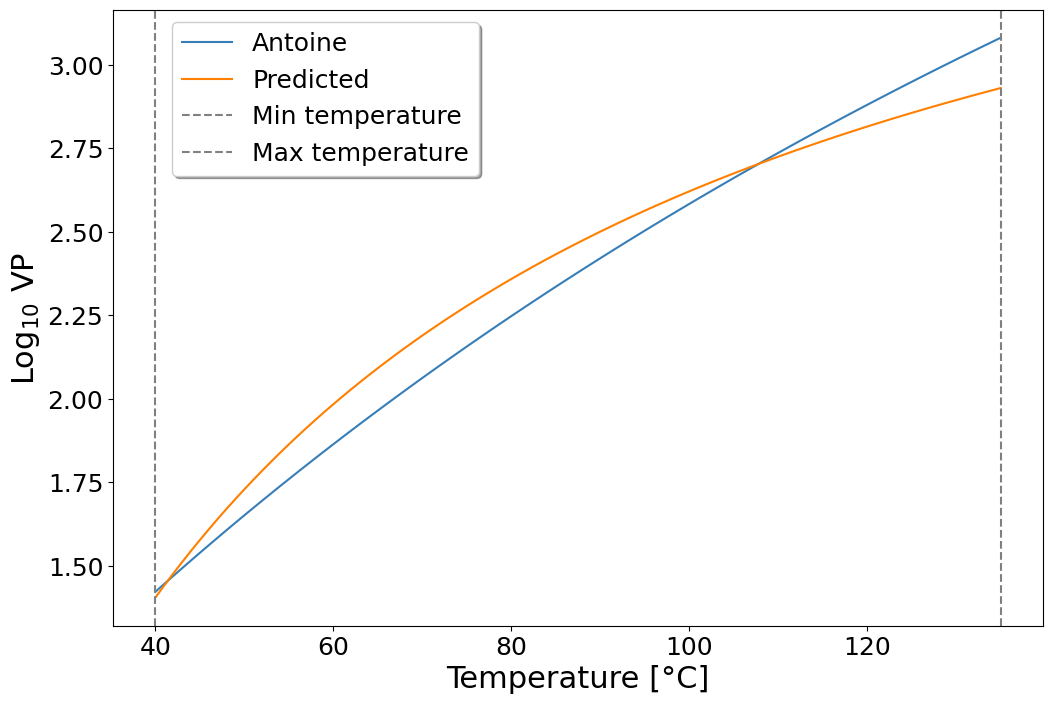

<Figure size 1200x800 with 0 Axes>

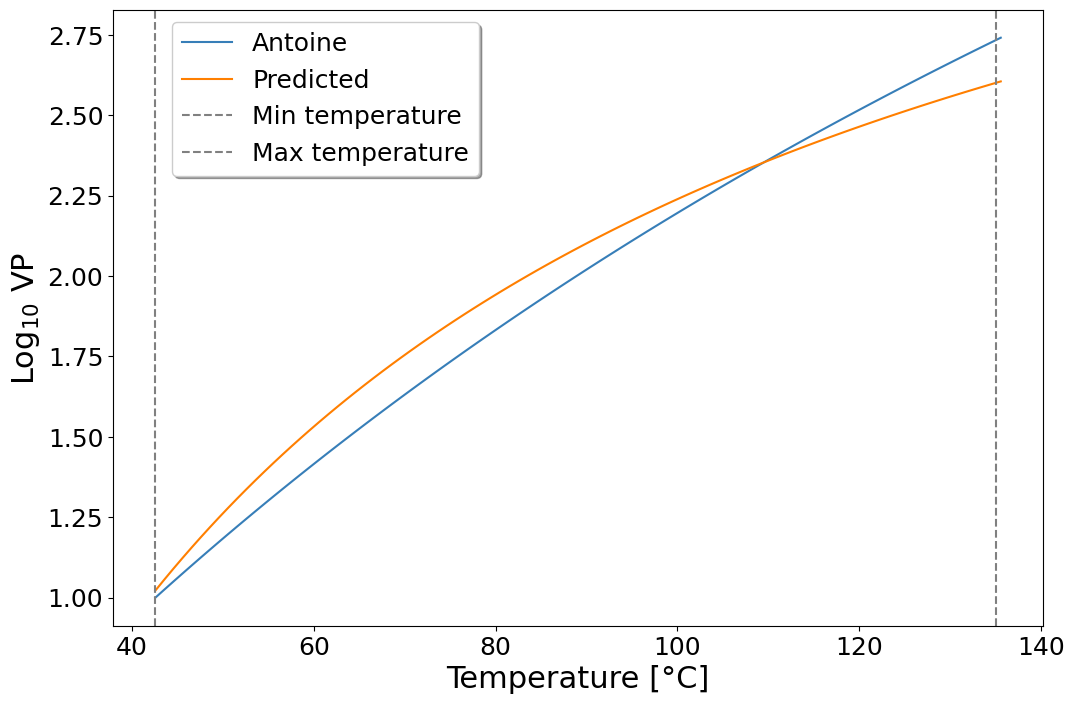

<Figure size 1200x800 with 0 Axes>

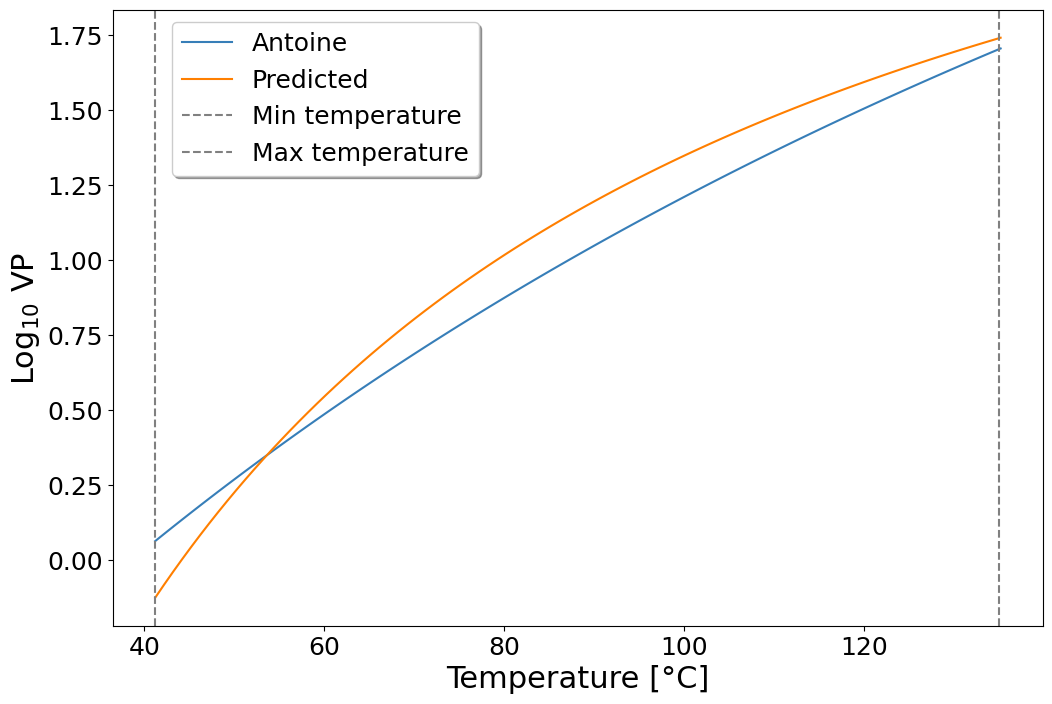

In [181]:
# Reset the style of the plots.
plt.style.use('default')

# Iterate over all the test data, and calculate Predicted log(P) - Actual log(P) for each molecule. 
df_test_predicted = pd.read_excel(f"Data/Amines_test.xlsx")

# Need to extract the antonine data for the molecules to compare. 
df_test_with_antonine = pd.read_excel(f"Data/Test.xlsx")
df_train_with_antonine = pd.read_excel(f"Data/Train.xlsx")

# Iterates over all the molecules in the test data.
max_improvement = 0
best_smiles_improvement = None
for index, smiles in enumerate(df_test_predicted["SMILES"].unique()):
    if smiles == "CCCN(CCC)CCO" or smiles == "CCN(CC)CCN" or smiles== "CNCCNC":
        
        # For extracting the antonine data
        df_antonine_one_molecule = df_test_with_antonine[df_test_with_antonine["SMILES"] == smiles]

        # Get the lowest and highest temperature for the molecule (will have the model extrapolate).
        # Minimum temperature should be minimum or 40, depending on which is the highest. 
        min_temp = df_antonine_one_molecule["TMIN"].item()
        max_temp = df_antonine_one_molecule["TMAX"].item()

        # Remove this for extrapolation.
        trained_on_min = min_temp
        trained_on_max = max_temp
        if min_temp < 40:
            trained_on_min = 40

        if max_temp > 135: 
            trained_on_max = 135

        # Generate a temperature range for the molecule.
        temperature_range = np.arange(trained_on_min, trained_on_max + 1, 1)

        # Calculates the true values for the amine in the whole range of temperatures.
        A = df_antonine_one_molecule["A"].item()
        B = df_antonine_one_molecule["B"].item()
        C = df_antonine_one_molecule["C"].item()
        pressure_true = []
        for temp in temperature_range:
            log_P = A - B / (temp + C)
            pressure_true.append(log_P)

        #print(f"True A, B, C: {A}, {B}, {C}")
        #print(smiles)
        # Calculate the predicted values for the amine in the whole range of temperatures.
        #temperature_range_10_points = np.linspace(trained_on_min, trained_on_max, 7)
        temperature_range_10_points = np.arange(trained_on_min, trained_on_max + 1, 1) # Wanted line instead of points

        pressure_predicted_amine = []
        A_pred, B_pred, C_pred = 0, 0, 0
        for temp in temperature_range_10_points:
            pressure, A_pred, B_pred, C_pred = model_prediction_amine([smiles], [temp])
                #print(A_pred, B_pred, C_pred)
            pressure_predicted_amine.append(pressure[0])


        # If extrapolation folder does not exist, create it.
        if not os.path.exists("Data/Final model (amines)/Interpolation_test_new"):
            os.makedirs("Data/Final model (amines)/Interpolation_test_new")

        # Get name 
        name = df_test_with_antonine[df_test_with_antonine["SMILES"] == smiles]["NAME"].item()
        name = name[0].upper() + name[1:]

        # Want to make figure larger
        plt.figure(figsize=(12,8)) 

        # Want to make figure larger
        plt.figure(figsize=(12,8)) 

        plt.plot(temperature_range, pressure_true, label="Antoine",  color=CB_color_cycle[0])
        # Add points as x
        plt.plot(temperature_range_10_points, pressure_predicted_amine, label="Predicted",  color=CB_color_cycle[1])
        #plt.scatter(temperature_range_10_points, pressure_predicted_amine, c=CB_color_cycle[1], alpha=0.9, edgecolors='w', s=70, label="Predicted")
        # Plot straight lines for the min and max temperature.
        plt.axvline(x=trained_on_min, color="gray", linestyle="--", label="Min temperature")
        plt.axvline(x=trained_on_max, color="gray", linestyle="--", label="Max temperature")
        plt.xlabel("Temperature [°C]", fontsize=22)
        plt.ylabel("Log$_{10}$ VP", fontsize=22)
        #plt.ylim(2,4)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        #plt.title(f"{name} ({smiles})", fontsize=22)
        #plt.legend(loc='lower left', bbox_to_anchor=(0.05, 1), shadow=True, fancybox=True, markerscale=1.5, fontsize=18)
        plt.legend(loc='upper left', bbox_to_anchor=(0.05, 1), shadow=True, fancybox=True, markerscale=1.5, fontsize=18)
        #plt.savefig(f"Data/Final model (amines)/Interpolation_test_new/{smiles}.png")
        plt.show()
        plt.close()


Extrapolation for individual molecules: 

Smiles:  CC1=CC(=C(C=C1C)N)C
True A, B, C: 7.32123, 1889.0587, 190.873


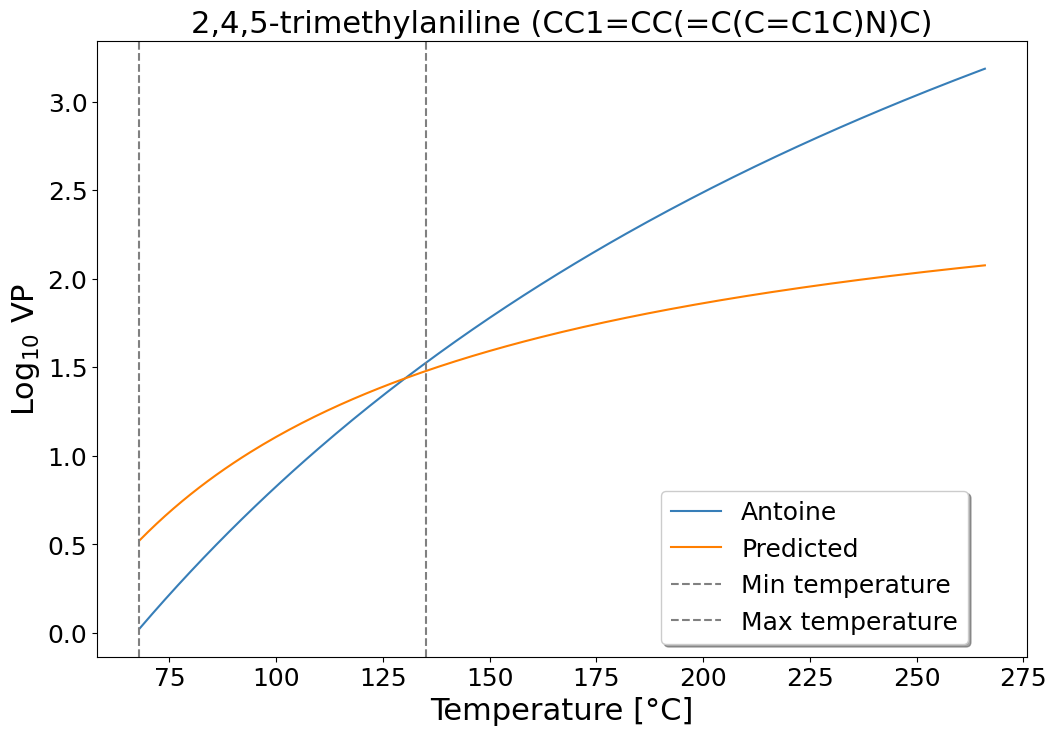

'\n\n    if smiles=="CCCN1CCCCC1" or smiles=="CC(C)CN1CCCCC1" or smiles=="CC(C)NCCCN(C)C" or smiles=="CC(CC(C)(C)N)N" or smiles=="C1CN1" or smiles=="C(=CF)N(C(F)(F)F)C(F)(F)F" or smiles=="CC1CN1" or smiles=="CCC(C)N" or smiles=="CCCN(C)C" or smiles=="CN1CCCC1" or smiles=="CNN" or smiles=="CCCC(CC)N":\n        # Want to plot the predicted and true values for the molecule.\n        plt.plot(temperature_range, pressure_true, label="True")\n        plt.plot(temperature_range, pressure_predicted, label="Predicted")\n        # Plot straight lines for the min and max temperature.\n        plt.axvline(x=min_temp, color="black", linestyle="--", label="Min temperature")\n        plt.axvline(x=max_temp, color="black", linestyle="--", label="Max temperature")\n        plt.xlabel("Temperature [°C]", fontsize=18)\n        plt.ylabel("log(P)", fontsize=18)\n        plt.title(f"Predicted vs. True log(P) for {smiles}", fontsize=18)\n        plt.legend()\n        plt.savefig(f"Data/Final model (amines)/

In [182]:
# Iterate over all the test data, and calculate Predicted log(P) - Actual log(P) for each molecule. 
df_test_predicted = pd.read_excel(f"Data/Amines_test.xlsx")

# Need to extract the antonine data for the molecules to compare.
df_test_with_antonine = pd.read_excel(f"Data/Test.xlsx")
"""
# Iterates over all the molecules in the test data.
max_improvement = 0
best_smiles_improvement = None
for index, smiles in enumerate(df_test_predicted["SMILES"].unique()):
    # The predicted data
    df_pred_one_molecule = df_test_predicted[df_test_predicted["SMILES"] == smiles]

    # For extracting the antonine data
    df_antonine_one_molecule = df_test_with_antonine[df_test_with_antonine["SMILES"] == smiles]

    # Get the lowest and highest temperature for the molecule (will have the model extrapolate).
    # Minimum temperature should be minimum or 40, depending on which is the highest. 
    min_temp = df_antonine_one_molecule["TMIN"].item()
    max_temp = df_antonine_one_molecule["TMAX"].item()

    # Remove this for extrapolation.
    trained_on_min = min_temp
    trained_on_max = max_temp
    if min_temp < 40:
        trained_on_min = 40

    if max_temp > 135: 
        trained_on_max = 135

    # Generate a temperature range for the molecule.
    temperature_range = np.arange(min_temp, max_temp + 1, 1)

    # Calculates the true values for the amine in the whole range of temperatures.
    A = df_antonine_one_molecule["A"].item()
    B = df_antonine_one_molecule["B"].item()
    C = df_antonine_one_molecule["C"].item()
    pressure_true = []
    for temp in temperature_range:
        log_P = A - B / (temp + C)
        pressure_true.append(log_P)

    #print(f"True A, B, C: {A}, {B}, {C}")
    #print(smiles)
    # Calculate the predicted values for the amine in the whole range of temperatures.
    pressure_predicted_amine = []
    A_pred, B_pred, C_pred = 0, 0, 0
    for temp in temperature_range:
        pressure, A_pred, B_pred, C_pred = model_prediction_amine([smiles], [temp])
            #print(A_pred, B_pred, C_pred)
        pressure_predicted_amine.append(pressure[0])

    # Calculate the predictions for the general model.
    pressure_predicted_general = []
    for temp in temperature_range:
        pressure, a, b, c = model_prediction_general([smiles], [temp])
        pressure_predicted_general.append(pressure[0])


    # If extrapolation folder does not exist, create it.
    if not os.path.exists("Data/Final model (amines)/Extrapolation"):
        os.makedirs("Data/Final model (amines)/Extrapolation")

    # Molecules that get weird results (zero division). 

    #if smiles=="CCCN1CCCCC1" or smiles=="CC(C)CN1CCCCC1" or smiles=="CC(C)NCCCN(C)C" or smiles=="CC(CC(C)(C)N)N" or smiles=="C1CN1" or smiles=="C(=CF)N(C(F)(F)F)C(F)(F)F" or smiles=="CC1CN1" or smiles=="CCC(C)N" or smiles=="CCCN(C)C" or smiles=="CN1CCCC1" or smiles=="CNN" or smiles=="CCCC(CC)N":

    # plot all molecules
    # Get name
    name = df_test_with_antonine[df_test_with_antonine["SMILES"] == smiles]["NAME"].item()
    name = name[0].upper() + name[1:]

    # Want to make figure larger
    plt.figure(figsize=(12,8))

    plt.plot(temperature_range, pressure_true, label="Antoine",  color=CB_color_cycle[0])
    # Add points as x
    plt.plot(temperature_range, pressure_predicted_amine, label="Predicted",  color=CB_color_cycle[1])
    #plt.scatter(temperature_range_10_points, pressure_predicted_amine, c=CB_color_cycle[1], alpha=0.9, edgecolors='w', s=70, label="Predicted")
    # Plot straight lines for the min and max temperature.
    plt.axvline(x=trained_on_min, color="gray", linestyle="--", label="Min temperature")
    plt.axvline(x=trained_on_max, color="gray", linestyle="--", label="Max temperature")
    plt.xlabel("Temperature [°C]", fontsize=22)
    plt.ylabel("Log$_{10}$ VP", fontsize=22)
    #plt.ylim(2,4)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title(f"{name} ({smiles})", fontsize=22)
    plt.legend(loc='upper left', bbox_to_anchor=(0.05, 1), shadow=True, fancybox=True, markerscale=1.5, fontsize=18)
    #plt.legend(loc='lower right', shadow=True, fancybox=True, markerscale=1.5, fontsize=18)
    plt.savefig(f"Data/Final model (amines)/Extrapolation/{smiles}.png")
    plt.close()
    

print(best_smiles_improvement)

tyuj
"""



smiles = "CC1=CC(=C(C=C1C)N)C"
#smiles = "CNN"
#smiles =  "CC(C)NCCCN(C)C"

#if smiles == "CNN" or smiles == "CC(C)NCCCN(C)C" or smiles== "CC1=CC(=C(C=C1C)N)C":

name = df_test_with_antonine[df_test_with_antonine["SMILES"] == smiles]["NAME"].item()

# Capitalize the first letter

name = name[0].upper() + name[1:]

# The predicted data
df_pred_one_molecule = df_test_predicted[df_test_predicted["SMILES"] == smiles]

# For extracting the antonine data
df_antonine_one_molecule = df_test_with_antonine[df_test_with_antonine["SMILES"] == smiles]

# Get the lowest and highest temperature for the molecule (will have the model extrapolate).
# Minimum temperature should be minimum or 40, depending on which is the highest. 
min_temp = df_antonine_one_molecule["TMIN"].item()
max_temp = df_antonine_one_molecule["TMAX"].item()

# Remove this for extrapolation.
trained_on_min = min_temp
trained_on_max = max_temp
if min_temp < 40:
    trained_on_min = 40

if max_temp > 135: 
    trained_on_max = 135

# Generate a temperature range for the molecule.
temperature_range = np.arange(min_temp, max_temp + 1, 1)

# Calculates the true values for the amine in the whole range of temperatures.
A = df_antonine_one_molecule["A"].item()
B = df_antonine_one_molecule["B"].item()
C = df_antonine_one_molecule["C"].item()
pressure_true = []
for temp in temperature_range:
    log_P = A - B / (temp + C)
    pressure_true.append(log_P)

print("Smiles: ", smiles)

print(f"True A, B, C: {A}, {B}, {C}")

#print(f"True A, B, C: {A}, {B}, {C}")
#print(smiles)
# Calculate the predicted values for the amine in the whole range of temperatures.

# Extract 10 uniformly distrubuted temperatures between the min and max temperature.


#temperature_range_10_points = np.linspace(trained_on_min, trained_on_max, 10)


pressure_predicted_amine = []
A_pred, B_pred, C_pred = 0, 0, 0
for temp in temperature_range:
    pressure, A_pred, B_pred, C_pred = model_prediction_amine([smiles], [temp])
    pressure_predicted_amine.append(pressure[0])

# Want to plot the predicted and true values for the molecule.

# Want to make figure larger
plt.figure(figsize=(12,8)) 

plt.plot(temperature_range, pressure_true, label="Antoine",  color=CB_color_cycle[0])
# Add points as x
plt.plot(temperature_range, pressure_predicted_amine, label="Predicted",  color=CB_color_cycle[1])
#plt.scatter(temperature_range_10_points, pressure_predicted_amine, c=CB_color_cycle[1], alpha=0.9, edgecolors='w', s=70, label="Predicted")
# Plot straight lines for the min and max temperature.
plt.axvline(x=trained_on_min, color="gray", linestyle="--", label="Min temperature")
plt.axvline(x=trained_on_max, color="gray", linestyle="--", label="Max temperature")
plt.xlabel("Temperature [°C]", fontsize=22)
plt.ylabel("Log$_{10}$ VP", fontsize=22)
#plt.ylim(2,4)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(f"{name} ({smiles})", fontsize=22)
#plt.legend(loc='lower left', bbox_to_anchor=(0.05, 1), shadow=True, fancybox=True, markerscale=1.5, fontsize=18)
plt.legend(loc='lower right', bbox_to_anchor=(0.95, 0), shadow=True, fancybox=True, markerscale=1.5, fontsize=18)
#plt.savefig(f"Data/Final model (amines)/Extrapolation_new/{smiles}.png")
plt.show()
plt.close()


        
"""

    if smiles=="CCCN1CCCCC1" or smiles=="CC(C)CN1CCCCC1" or smiles=="CC(C)NCCCN(C)C" or smiles=="CC(CC(C)(C)N)N" or smiles=="C1CN1" or smiles=="C(=CF)N(C(F)(F)F)C(F)(F)F" or smiles=="CC1CN1" or smiles=="CCC(C)N" or smiles=="CCCN(C)C" or smiles=="CN1CCCC1" or smiles=="CNN" or smiles=="CCCC(CC)N":
        # Want to plot the predicted and true values for the molecule.
        plt.plot(temperature_range, pressure_true, label="True")
        plt.plot(temperature_range, pressure_predicted, label="Predicted")
        # Plot straight lines for the min and max temperature.
        plt.axvline(x=min_temp, color="black", linestyle="--", label="Min temperature")
        plt.axvline(x=max_temp, color="black", linestyle="--", label="Max temperature")
        plt.xlabel("Temperature [°C]", fontsize=18)
        plt.ylabel("log(P)", fontsize=18)
        plt.title(f"Predicted vs. True log(P) for {smiles}", fontsize=18)
        plt.legend()
        plt.savefig(f"Data/Final model (amines)/Interpolation/{smiles}.png")
        plt.close()

"""


    #change_in_pressure_list.append(df_temp["Predicted log(P)"].iloc[-1] - df_temp["Predicted log(P)"].iloc[0])
    #change_in_temperature_list.append(max_temp - min_temp)


#for smiles_string in df_test["SMILES"]:
#    model_prediction(SMILES, temperature)

# VLE model 

The best combined model ended up being the one that had variable alpha, and that used the sum in the loss function to constrain the model. Split training test 75/25, and then tried different split ratios for train and validation and tried 10 different initializations for each split to find the best model. Performing different initializations for the other previous models would have been very extensive -> A lot more data, so would be slower. Also, earlier I performed cross-validation which took a lot of time. 

Best was 80/20 split with 89 as the random seed (used same seed for all the splits). 

In [285]:
num_of_features = 9
best_config = {'num_gcn_layers': 4, 'num_hidden_layers': 4, 'GCN_output_per_layer': [100, 420, 140, 140], 'hidden_neurons_per_layer': [260, 60, 180, 100], 'learning_rate': 0.007425096728429009, 'size_of_batch': 128, 'number_of_epochs': 600, 'number_of_temp': 7, 'min_interval': 20, 'patience': 50, 'dropout_rate': 0.2,  'activation_function': 'relu', 'decay_rate': 0.95}

def extract_VLE_data(excel_filename, path_to_code):
    """
    Extracts the data that will be used for training and validating the model.
    """

    # Locates the file for the training data.
    excel_file_VLE = pd.ExcelFile(f"{path_to_code}/Data/Combined model/{excel_filename}")

    # Locates the file for the SMILES notation.
    smiles_converter = pd.read_excel(f"{path_to_code}/Data/All_amines.xlsx")

    # Only want the columns "CAS No" and "SMILES"
    smiles_converter = smiles_converter[["CAS No", "SMILES"]]

    # Dictionary to store the data. The key is the SMILES notation and the value is the VLE data.
    dev_dict = {}

    for sheet in excel_file_VLE.sheet_names:
        # Get the correct SMILES notation for the compound.
        smiles_value = smiles_converter.loc[smiles_converter["CAS No"] == sheet, "SMILES"].values[0]
        dev_dict[smiles_value] = pd.read_excel(excel_file_VLE, sheet_name=sheet)

    return dev_dict


def saturation_pressure_water(T):
    """
    This function calculates the saturation pressure of water at a given temperature. These formulas are based on the
    Antoine equation recived from the Dortmund Data Bank.
    """

    # Initialize a tensor for P with the same shape as T and fill it with NaNs.
    P = torch.full_like(T, float('nan'))

    # Condition for temperature range 1 to 100 degrees Celsius
    condition1 = (T > 1) & (T < 100)
    A1 = 8.07131
    B1 = 1730.63
    C1 = 233.426
    P[condition1] = 10**(A1 - B1 / (T[condition1] + C1))

    # Condition for temperature range 100 to 374 degrees Celsius
    condition2 = (T >= 100) & (T < 374)
    A2 = 8.14019
    B2 = 1810.94
    C2 = 244.485
    P[condition2] = 10**(A2 - B2 / (T[condition2] + C2))

    return P


class NRTLEquationLayer(nn.Module):
    def __init__(self):
        """
        Initialize the custom layer. 
        """
        super(NRTLEquationLayer, self).__init__()

    def forward(self, x_in, temperature, mole_frac_amine, mole_frac_water):
        """
        x_in have four elements representing alpha, b_12, and b_21 coefficients.
        """

        # Extract the interaction parameters. 
        alpha, b_12, b_21 = x_in[:, 0], x_in[:, 1], x_in[:, 2]

        # Sets alpha to be constant at 0.3 -> Better to let it vary. 
        #alpha = 0.3
        alpha_min = 0.2
        alpha_max = 0.47

        # Scales alpha from 0 to 1
        #alpha = torch.sigmoid(alpha)
        # Scales alpha from [alpha_min, alpha_max]
        #alpha = alpha_min + (alpha_max - alpha_min) * alpha

        # Calculate alpha to get it in that range (from spt-nrtl paper)
        alpha = alpha_min * (1 + torch.sigmoid(alpha)/10 * ((alpha_max/alpha_min)))

        # Gas constant in mmHg
        R = 62.36367 # mmHg L / mol K

        # The temperature in Kelvin
        temperature = temperature + 273.15

        # Calculate tau 
        tau_12 = b_12/(R*temperature)
        tau_21 = b_21/(R*temperature)

        # Calculate G
        G_12 = torch.exp(-tau_12 * alpha)
        G_21 = torch.exp(-tau_21 * alpha)

        # Calculate the activity coefficients
        ln_gamma_amine = mole_frac_water**2 * (tau_21 * (G_21 / (mole_frac_amine + mole_frac_water * G_21) )**2 + (tau_12 * G_12)/( mole_frac_water + mole_frac_amine*G_12 )**2)
        ln_gamma_water = mole_frac_amine**2 * (tau_12 * (G_12 / (mole_frac_water + mole_frac_amine * G_12) )**2 + (tau_21 * G_21)/( mole_frac_amine + mole_frac_water*G_21 )**2)

        return ln_gamma_amine, ln_gamma_water


class GNN_Activity_coeff(nn.Module):
    """
    This class defines the structure of the model. The model will be a graph neural network (GNN) model. The model
    inherits from the nn.Module class, which is the base class for all neural network modules in PyTorch. 
    """

    def __init__(self, config, num_of_features):
        # Defines the structure of the model. 
        super().__init__()

        # Set the activation function.
        if config["activation_function"] == "relu":
            self.activation = nn.ReLU()

        elif config["activation_function"] == "sigmoid":
            self.activation = nn.Sigmoid()

        elif config["activation_function"] == "tanh":
            self.activation = nn.Tanh()

        # Initialize GCN layers and activations as ModuleList
        self.GCN_layers = nn.ModuleList()
        self.GCN_activations = nn.ModuleList()

        # Adds the GCN layers and the activation functions to the model.
        for i in range(best_config["num_gcn_layers"]):
            self.GCN_layers.append(GCNConv(num_of_features, best_config["GCN_output_per_layer"][i]))
            self.GCN_activations.append(self.activation)
            num_of_features = best_config["GCN_output_per_layer"][i]

        # Adds the global pooling layer.
        self.global_pooling = global_add_pool
        self.global_pooling_activation = self.activation

        # Initialize dense layers and activations as ModuleList
        self.dense_layers = nn.ModuleList()
        self.dense_activations = nn.ModuleList()
        self.dropout = nn.ModuleList()

        # Adds the dense layers and the activation functions to the model.
        for i in range(best_config["num_hidden_layers"]):
            self.dense_layers.append(nn.Linear(num_of_features, best_config["hidden_neurons_per_layer"][i]))
            self.dense_activations.append(self.activation)
            self.dropout.append(nn.Dropout(p=best_config["dropout_rate"]))
            num_of_features = best_config["hidden_neurons_per_layer"][i]

        # Adds the NRTL coefficients layer.
        self.NRTL_coeff = nn.Linear(num_of_features, 3)
        
        # Initilize the NRTRL layer
        self.nrtl_layer = NRTLEquationLayer()

    def forward(self, x, edge_indices, batch_mapping, temperature, mean, std, mole_frac_amine, mole_frac_water):
        # Defines the forward pass of the model. This is where the data is input to the model.

        #print(f"Input shape: {x.shape}")
        # Iterates over all the GCN layers and the activation functions.
        for layer, act in zip(self.GCN_layers, self.GCN_activations):
            # Performs the message passing and then applies the activation function. Edge index says which atoms 
            # that are connected. 
            x = act(layer(x, edge_indices))
            #print(f"After GCN Layer {layer}: {x.shape}")

        # Apply global pooling. Here we need batch_mapping to map which atoms that belongs to which molecule.
        x = self.global_pooling(x, batch_mapping)
        x = self.global_pooling_activation(x)
        #print(f"After Global Pooling: {x.shape}")

        # Iterates over all the dense layers and the activation functions.
        for layer, act, drop in zip(self.dense_layers, self.dense_activations, self.dropout):
            # Applies the dense layer and then the activation function.
            x = act(layer(x))
            # Apply dropout
            x = drop(x)
            #print(f"After Dense Layer {layer}: {x.shape}")

        # Apply the Antoine coefficients layer
        x = self.NRTL_coeff(x)
        #print(f"After NRTL Coefficients Layer: {x.shape}")

        ln_gamma_amine, ln_gamma_water = self.nrtl_layer(x, temperature, mole_frac_amine, mole_frac_water)
        #print(f"Final Output Shape: {log_P.shape}")

        return ln_gamma_amine, ln_gamma_water


class VLE_model(nn.Module):
    """
    This class defines the structure of the model. The model will be a graph neural network (GNN) model. The model
    inherits from the nn.Module class, which is the base class for all neural network modules in PyTorch. 
    """

    def __init__(self, GCN_saturation, mean_gcn, std_gcn, best_config, num_of_features):
        # Defines the structure of the model. 
        super().__init__()

        # Initialize the GCN saturation model with the pre-trained model. Also initilize the mean and standard deviation for scaling.
        self.GCN_saturation = GCN_saturation
        self.mean_gcn = mean_gcn
        self.std_gcn = std_gcn

        # Initilize the NRTL model
        self.NRTL_model = GNN_Activity_coeff(best_config, num_of_features)


    def forward(self, batch):
        """ Defines the forward pass of the model. This is where the data is input to the model. """

        # Unpack the batch
        (x, edge_indices, batch_mapping), x_water, x_amine, y_water, y_amine, temperature, P_tot = batch

        # Calculate the predictions of the GCN model
        log_P_normalized = self.GCN_saturation(x, edge_indices, batch_mapping, temperature, self.mean_gcn, self.std_gcn)
        # Only the first element as the others are the antoine coefficents
        log_P_normalized = log_P_normalized[0]
        log_P = log_P_normalized * self.std_gcn + self.mean_gcn
        P_amine = 10**log_P
        ln_P_amine = torch.log(P_amine)

        # Convert total pressure from Pa to mmHg
        P_tot = P_tot / 133.322

        # Take the natural logarithm of the total pressure, water fraction and amine fraction
        ln_P_tot = torch.log(P_tot)
        ln_x_water = torch.log(x_water)
        ln_x_amine = torch.log(x_amine)

        # Calculate the predictions of the NRTL model (activity coefficients)
        ln_gamma_amine, ln_gamma_water = self.NRTL_model(x, edge_indices, batch_mapping, temperature, self.mean_gcn, self.std_gcn, x_amine, x_water)

        # Calculate the saturation pressure of water
        P_water = saturation_pressure_water(temperature)
        ln_P_water = torch.log(P_water)

        # Calculate ln_y_amine and ln_y_water
        ln_y_amine_pred = ln_x_amine + ln_gamma_amine + ln_P_amine - ln_P_tot
        ln_y_water_pred = ln_x_water + ln_gamma_water + ln_P_water - ln_P_tot

        # Want to return the predictions of the amine and water fractions. 
        sum_ln_y = ln_y_amine_pred + ln_y_water_pred

        return torch.stack((ln_y_amine_pred, ln_y_water_pred, sum_ln_y), dim=1)

In [293]:
def merge_batch_VLE(batch):
    """
    This function merge the graphs in the batch into a larger batch by concatenating node features and computing new
    edge indices. Batch is on the format [(graph1, target1), (graph2, target2), ...], and the output is on the format
    (merged_nodes, merged_edge_indices, merged_batch_mapping), merged_targets, merged_temperatures.

    Further, merged_nodes is on the format [node1, node2, ...], merged_edge_indices is on the format [edge1, edge2, ...]
    and merged_batch_mapping is on the format [0, 0, ..., 1, 1, ...], where the length of the lists are the number of
    nodes and edges in the merged graph, respectively. The merged_targets is on the format [target1, target2, ...].
    The merged_temperatures is on the format [temperature1, temperature2, ...].
    """

    # Separate out nodes, adjacency matrices, scalar tensors, and temperatures
    nodes_list = [item[0][0] for item in batch]
    adj_list = [item[0][1] for item in batch]
    x_water_tensor = [item[1] for item in batch]
    x_amine_tensor = [item[2] for item in batch]
    y_water_tensor = [item[3] for item in batch]
    y_amine_tensor = [item[4] for item in batch]
    temperatures = [item[5] for item in batch]
    P_tot = [item[6] for item in batch]

    # Placeholder for the combined nodes
    merged_nodes = []
    # Placeholder for the combined edge indices (plural for index) -> says something about connections
    edge_indices = []
    # Placeholder for the batch mapping -> says something about which node that belongs to which graph! Important for
    # tying things together.
    batch_mapping = []

    # This will keep track of the current node index offset in the combined graph -> how much we must "shift" the
    # edge matrix
    current_node_index = 0

    # Iterates over all the graphs
    for idx, (nodes, adj) in enumerate(zip(nodes_list, adj_list)):
        # Extracts the number of nodes in the current graph.
        num_nodes = nodes.shape[0]

        # Add the current graph's nodes to the merged node list. Can append as usual, since we want to add rows.
        merged_nodes.append(nodes)

        # Converts the adjacency matrix to the correct edge index format required for the GCN layer. In other words, we
        # find the edges in the adjacency matrix, and offset them by the current node index.
        edges = adj.nonzero().t()
        edges = edges + current_node_index

        # Add the current graph's edges to the combined list
        edge_indices.append(edges)

        # Create the batch mapping for the current graph
        batch_mapping.extend([idx] * num_nodes)

        # Update the node index offset
        current_node_index += num_nodes

    # Convert the merged node list to a tensor
    merged_nodes_tensor = torch.cat(merged_nodes, dim=0)

    # Convert the edge index lists to a single tensor
    merged_edge_indices_tensor = torch.cat(edge_indices, dim=1)

    # Convert the batch mapping to a tensor
    batch_mapping_tensor = torch.tensor(batch_mapping, dtype=torch.long)

    # Convert x_water_tensor, x_amine_tensor, y_water_tensor, y_amine_tensor, temperature_tensor and P_tot_tensor to single tensors.
    x_water_tensor = torch.stack(x_water_tensor)
    x_amine_tensor = torch.stack(x_amine_tensor)
    y_water_tensor = torch.stack(y_water_tensor)
    y_amine_tensor = torch.stack(y_amine_tensor)
    temperature_tensor = torch.stack(temperatures)
    P_tot_tensor = torch.stack(P_tot)

    return (merged_nodes_tensor, merged_edge_indices_tensor, batch_mapping_tensor), x_water_tensor, x_amine_tensor, y_water_tensor, y_amine_tensor, temperature_tensor, P_tot_tensor


class MolecularDatasetVLE(Dataset):
    """
    This class is needed to create our dataset (on the Dataset format).
    The class inherits from the Dataset class. Input is on format X and T, where X is the SMILES notation and T is the
    temperature. 
    """

    def __init__(self, data):
        # Initializes the features and targets. Is our constructor.
        self.SMILES = data[0]
        self.x_water = data[1]
        self.x_amine = data[2]
        self.y_water = data[3]
        self.y_amine = data[4]
        self.temperature = data[5]
        self.P_tot = data[6]

    def __len__(self):
        # Returns the length of the dataset
        return len(self.SMILES)

    def __getitem__(self, idx):
        # Extract the SMILES value of the molecule, calculate the graphs based on that SMILE, and then return this
        # value along with the corresponding target value.
        SMILES_one_molecule = self.SMILES[idx]
        nodes, adj = smiles2graph(SMILES_one_molecule)

        # Convert nodes and adj to tensors, assuming they are NumPy arrays returned from smiles2graph
        nodes_tensor = torch.tensor(nodes, dtype=torch.float32)
        adj_tensor = torch.tensor(adj, dtype=torch.float32)

        # Convert x_water, x_amine, y_water, y_amine, temperature and pressure to tensors.
        x_water_tensor = torch.tensor(self.x_water[idx], dtype=torch.float32)
        x_amine_tensor = torch.tensor(self.x_amine[idx], dtype=torch.float32)
        y_water_tensor = torch.tensor(self.y_water[idx], dtype=torch.float32)
        y_amine_tensor = torch.tensor(self.y_amine[idx], dtype=torch.float32)
        temperature_tensor = torch.tensor(self.temperature[idx], dtype=torch.float32)
        P_tot_tensor = torch.tensor(self.P_tot[idx], dtype=torch.float32)

        return (nodes_tensor, adj_tensor), x_water_tensor, x_amine_tensor, y_water_tensor, y_amine_tensor, temperature_tensor, P_tot_tensor


def VLE_prediction(SMILES, temperature, x_water, x_amine, P_tot):

    # Extracts the mean and standard deviation for scaling. We use the same scaling as before. 
    mean_gcn, std_gcn = extract_mean_std(best_config["number_of_temp"], best_config["min_interval"])

    # Create a dummy dataset for the y_values (will only be used for converting the SMILES etc to correct format for model)
    y_water = [1]*len(SMILES)
    y_amine = [1]*len(SMILES)
    data = [[SMILES], [x_water], [x_amine], y_water, y_amine, [temperature], [P_tot]]

    # Convert SMILES to graphs etc.
    converted_dataset = MolecularDatasetVLE(data)

    # Creating a DataLoader.
    loader = DataLoader(converted_dataset, batch_size=1, collate_fn=merge_batch_VLE, shuffle=False)

    # Initilize the model with the best hyperparameters. # Initilize and load the best gcn model for predicting amine pressure from earlier training.
    gcn_saturation = GNNModel(num_of_features, best_config["num_gcn_layers"], best_config["num_hidden_layers"], best_config["hidden_neurons_per_layer"], best_config["GCN_output_per_layer"], best_config["dropout_rate"], best_config["activation_function"])

    # Initilize the new model that will be trained.
    model = VLE_model(gcn_saturation, mean_gcn, std_gcn, best_config, num_of_features)

    # Now want to evaluate how this model performs on the training data. 
    # Load the already existing model 
    model.load_state_dict(torch.load(f"Data/Best combined model/Best_model.pt"))

    # Put the model in evaluation mode
    model.eval()
    
    with torch.no_grad():
        for index, batch in enumerate(loader):
            # Calculate the predictions for the given batch.
            y_hat = model(batch)

            return y_hat

The "VLE_prediction" function can be used to make predictions as demonstrated below. 

In [294]:
SMILES = "CN1CCNCC1"
x_water = 0.5414
x_amine = 1 - x_water
temperature = 115.05             # Should be given in C
P_tot = 101300                   # Should be given in Pa
prediction = VLE_prediction(SMILES, temperature, x_water, x_amine, P_tot)

ln_y_amine, ln_y_water = prediction[0][0].item(), prediction[0][1].item()

print("ln_y_amine: ", ln_y_amine)
print("ln_y_water: ", ln_y_water)


ln_y_amine:  -1.7621064186096191
ln_y_water:  -0.12092828750610352


### Learning Curve

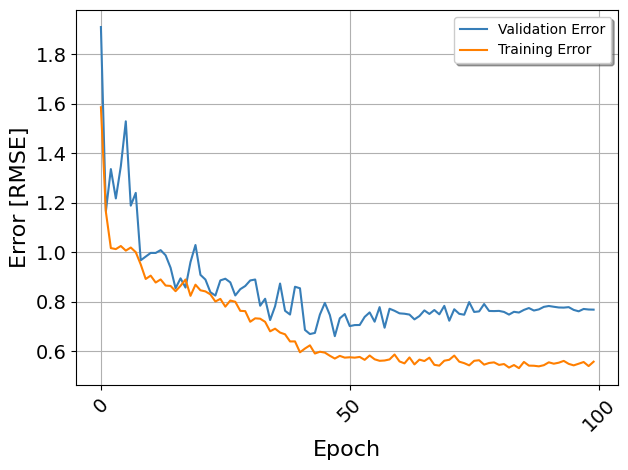

In [155]:
# Set the style back to default 
plt.style.use('default')

# Extracts the cross validation data for the best general model.
df_validation = pd.read_excel(f"/Users/kristoffer/Documents/5.Klasse/2. Semester/Code/Data/Combined model/GCN models/Split ratio = 0.8/89/Validation_error.xlsx")

# Extract the average validation error.
average_validation_error = df_validation["Average"].tolist()

# Want to convert the validation error from MSE to RMSE.
average_validation_error = [val_error ** 0.5 for val_error in average_validation_error]

# Do the same for the training error.   
df_train = pd.read_excel(f"/Users/kristoffer/Documents/5.Klasse/2. Semester/Code/Data/Combined model/GCN models/Split ratio = 0.8/89/Train_error.xlsx")
average_train_error = df_train["Average"].tolist()
average_train_error = [train_error ** 0.5 for train_error in average_train_error]

# Want to plot this to visualize the optimal number of epochs. x-axis is the epoch number and y-axis the validation error.
plt.plot(average_validation_error, label="Validation Error", color=CB_color_cycle[0])
plt.plot(average_train_error, label="Training Error", color=CB_color_cycle[1])
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Error [RMSE]", fontsize=16)
#plt.title("Error for each epoch", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Want to rotate the x-axis labels by 90 degrees so they don't overlap
plt.xticks(rotation=45)
# include grids for every 50 epochs
plt.xticks(np.arange(0, len(average_validation_error) + 50, 50))
plt.grid()
plt.legend(shadow=True, fancybox=True, markerscale=1.5)
plt.tight_layout()
plt.show()    

Note that the code below does not utilize the VLE model above for generating predictions, as the predictions for my training and test set was estimated during development in "GNN_combined_models.py", and the corresponding results saved in the excel files given below. However, using the model above would give the exact same results. 

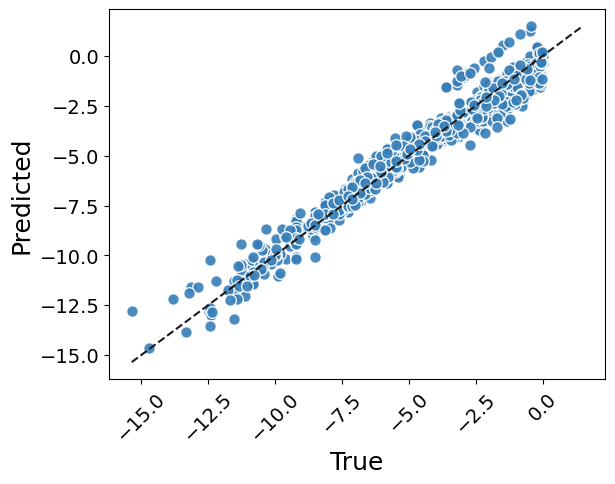

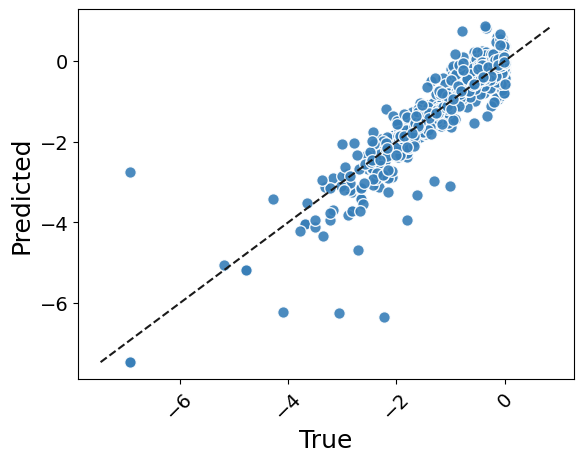

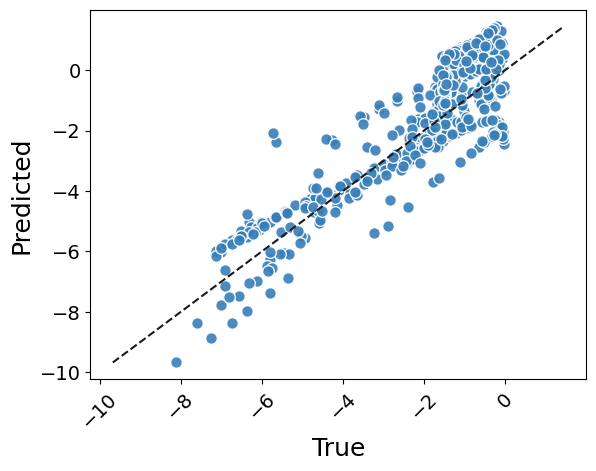

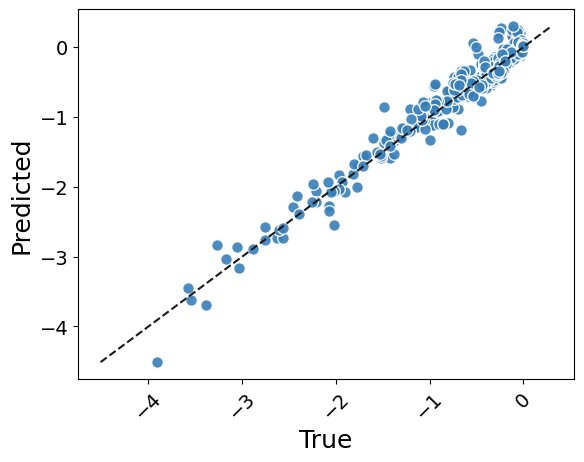

In [295]:
# Load predictions for the combined model. 
df_train_predicted = pd.read_excel(f"Data/Best combined model/Final evaluation/Predicted_values_train.xlsx")
df_test_predicted = pd.read_excel(f"Data/Best combined model/Final evaluation/Predicted_values_test.xlsx")

# Create parity plot for amine
def create_parity_plot_combined(y_hat_values, target_values, train_test_val, water_or_amine):
    # Plotting the parity line (identity line), that represents a perfect fit. To do this, we need to find the
    # maximum y value (can either be from the actual y value or the predicted value). We also need the minimum value.
    max_val = max(max(y_hat_values), max(target_values))
    min_val = min(min(y_hat_values), min(target_values))

    X_val_list = [min_val, max_val]
    y_val_list = [min_val, max_val]

    # Create a line between the minimum value and the maximum value. Note that here we have a list of X -values and lis
    plt.figure()
    # Want the x-axis and y-axis numbers to be larger so it becomes easier to read
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # Want to rotate the x-axis labels by 90 degrees so they don't overlap
    plt.xticks(rotation=45)

    # Scatter plot of predicted vs. actual values.
    plt.scatter(target_values, y_hat_values, c=CB_color_cycle[0], alpha=0.9, edgecolors='w', s=70)
    
    plt.plot(X_val_list, y_val_list, 'k--')

    # Creates title and labels
    plt.xlabel('True', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    #plt.title(f"{water_or_amine} - {train_test_val}", fontsize=18)
    plt.show()
    plt.close()

# Create the parity plots for the training data for the combined model.
log_y_amine_pred_train =  df_train_predicted["Predicted log(y_amine)"].tolist()
log_y_amine_target_train = df_train_predicted["Actual log(y_amine)"].tolist()
log_y_water_pred_train = df_train_predicted["Predicted log(y_water)"].tolist()
log_y_water_target_train = df_train_predicted["Actual log(y_water)"].tolist()
temperature_train = df_train_predicted["Temperature"].tolist()
create_parity_plot_combined(log_y_amine_pred_train, log_y_amine_target_train, "Train", "Amine")
create_parity_plot_combined(log_y_water_pred_train, log_y_water_target_train, "Train", "Water")

# Create the parity plots for the test data for the combined model.
log_y_amine_pred_test =  df_test_predicted["Predicted log(y_amine)"].tolist()
log_y_amine_target_test = df_test_predicted["Actual log(y_amine)"].tolist()
log_y_water_pred_test = df_test_predicted["Predicted log(y_water)"].tolist()
log_y_water_target_test = df_test_predicted["Actual log(y_water)"].tolist()
temperature_test = df_test_predicted["Temperature"].tolist()
create_parity_plot_combined(log_y_amine_pred_test, log_y_amine_target_test, "Test", "Amine")
create_parity_plot_combined(log_y_water_pred_test, log_y_water_target_test, "Test", "Water")

/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/1788756086.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True, color=CB_color_cycle[0], bw_adjust=0.8)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


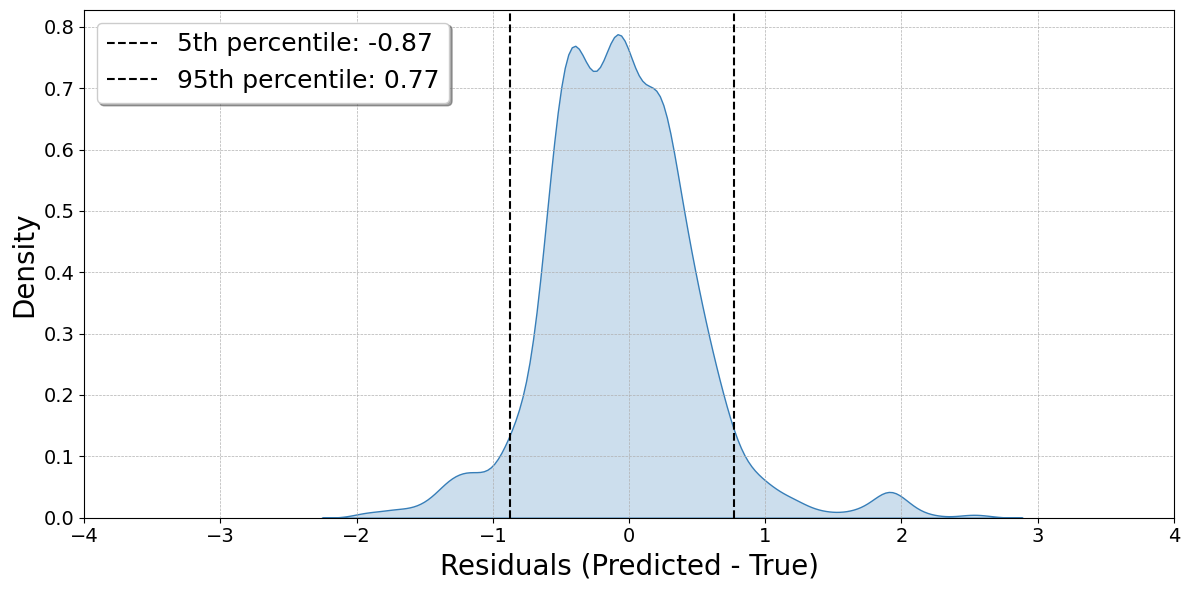

/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/1788756086.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True, color=CB_color_cycle[0], bw_adjust=0.8)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


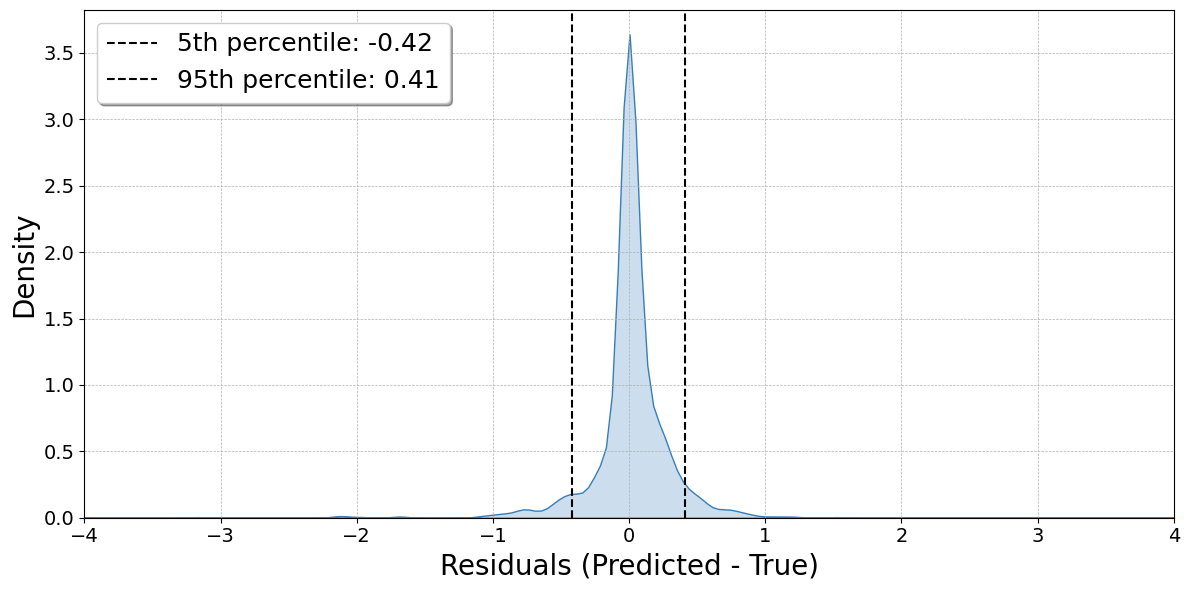

/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/1788756086.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True, color=CB_color_cycle[0], bw_adjust=0.8)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


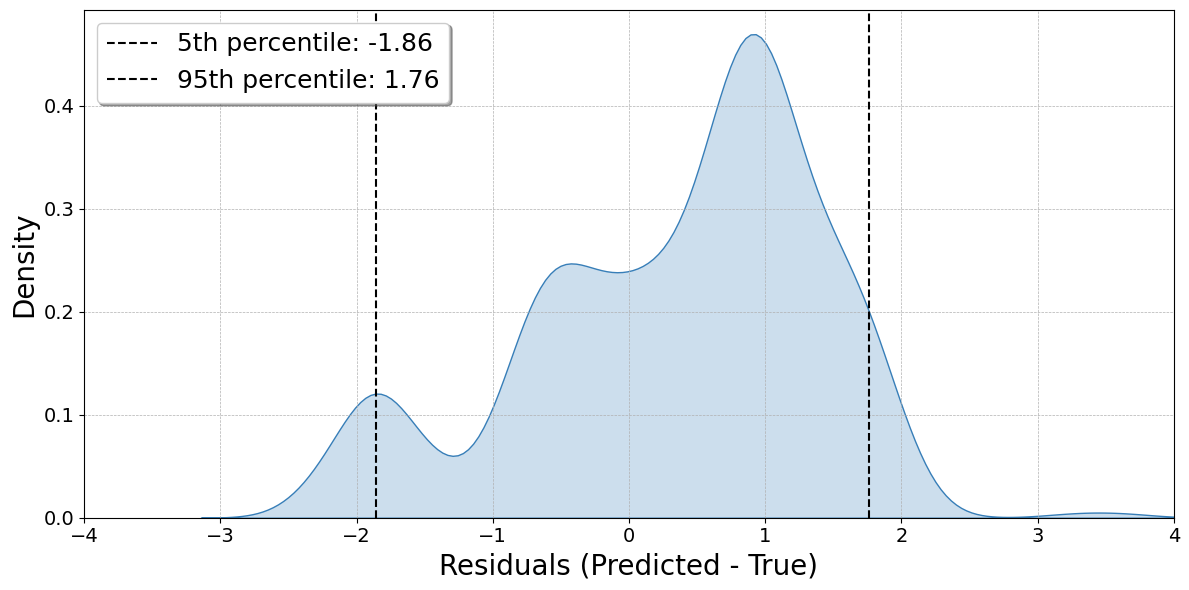

/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_2379/1788756086.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True, color=CB_color_cycle[0], bw_adjust=0.8)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


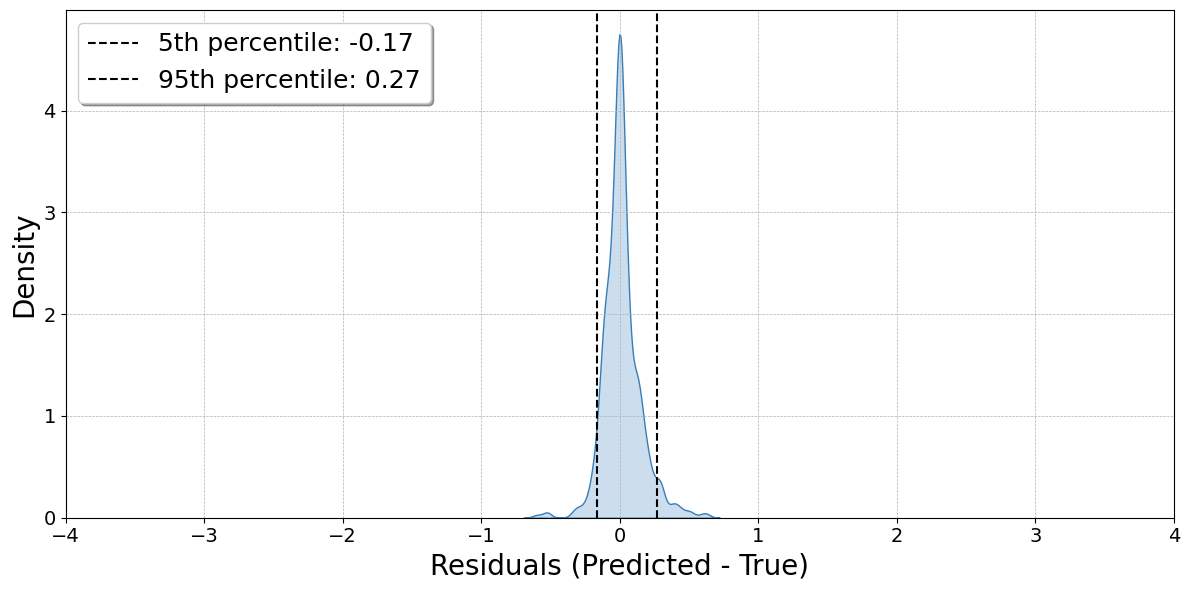

RMSE for amine test data: 1.1250829383341074
RMSE for water test data: 0.1359708309410195


In [297]:
# Want to create the kernel density estimation plots for the combined model.
def create_kde_plot_combined(y_hat_values, target_values, title):
    # Calculate the differences between predicted and actual values
    residuals = [y_hat - y_true for y_hat, y_true in zip(y_hat_values, target_values)]

    plt.figure(figsize=(12, 6))
    sns.kdeplot(residuals, shade=True, color=CB_color_cycle[0], bw_adjust=0.8)
    #plt.title(f'KDE of LogY - {title}', fontsize=18)
    plt.xlabel('Residuals (Predicted - True)', fontsize=20)
    plt.ylabel('Density', fontsize=20)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(-4, 4)
    plt.legend(loc='upper left', shadow=True, fancybox=True, markerscale=1.5, fontsize=18) 
    plt.tight_layout()

    # Calculate the 95% confidence interval
    lower_bound = np.percentile(residuals, 5)
    upper_bound = np.percentile(residuals, 95)

    # Annotate the 95% confidence interval on the plot
    plt.axvline(lower_bound, color='black', linestyle='--', linewidth=1.5, label=f'5th percentile: {lower_bound:.2f}')
    plt.axvline(upper_bound, color='black', linestyle='--', linewidth=1.5, label=f'95th percentile: {upper_bound:.2f}')
    plt.legend(loc='upper left', shadow=True, fancybox=True, markerscale=1.5, fontsize=18)
    plt.show()
    plt.close()


# Create the kernel density estimation plots for the training data for the combined model.
create_kde_plot_combined(log_y_amine_pred_train, log_y_amine_target_train, "Amine (train)")
create_kde_plot_combined(log_y_water_pred_train, log_y_water_target_train, "Water (train)")

# Create the kernel density estimation plots for the test data for the combined model.
create_kde_plot_combined(log_y_amine_pred_test, log_y_amine_target_test, "Amine (test)")
create_kde_plot_combined(log_y_water_pred_test, log_y_water_target_test, "Water (test)")

# Want to calculate RMSE for the test data for both the amine and water.

rmse_amine_test = 0 

for pred, true in zip(log_y_amine_pred_test, log_y_amine_target_test):
    rmse_amine_test += (pred - true) ** 2

rmse_amine_test /= len(log_y_amine_pred_test)
rmse_amine_test = np.sqrt(rmse_amine_test)

print(f"RMSE for amine test data: {rmse_amine_test}")

rmse_water_test = 0

for pred, true in zip(log_y_water_pred_test, log_y_water_target_test):
    rmse_water_test += (pred - true) ** 2

rmse_water_test /= len(log_y_water_pred_test)
rmse_water_test = np.sqrt(rmse_water_test)

print(f"RMSE for water test data: {rmse_water_test}")

In [ ]:
temperatures_test = df_test_predicted["Temperature"].tolist()

amount_40_to_70 = len([temp for temp in temperatures_test if temp < 70])
amount_70_to_100 = len([temp for temp in temperatures_test if temp < 100 and temp >= 70])
amount_100_to_135 = len([temp for temp in temperatures_test if temp >= 100])
total_amount = len(temperatures_test)

print(f"Amount of test data with temperature between 40°C and 70°C: {amount_40_to_70/total_amount*100:.2f}%")
print(f"Amount of test data with temperature between 70°C and 100°C: {amount_70_to_100/total_amount*100:.2f}%")
print(f"Amount of test data with temperature between 100°C and 135°C: {amount_100_to_135/total_amount*100:.2f}%")

Amount of test data with temperature between 40°C and 70°C: 24.40%
Amount of test data with temperature between 70°C and 100°C: 57.34%
Amount of test data with temperature between 100°C and 135°C: 18.25%


# PubChem data

This part is probably not useful, but left it here just in case. 

In [ ]:
from collections import Counter
# Read the Excel file and create a DataFrame
df_2 = pd.read_excel('pubchem_pressures.xlsx')

T = []
P = []
canonical_smiles = []

for index, row in df_2.iterrows():
    for col in df_2.columns:
        if col.startswith("Pressure"):
            value = row[col]
            if pd.notnull(value):
                # Extract the temperature and pressure values from the string
                temperature = value[value.find("(")+1:value.find(")")]
                pressure = value[value.find("=")+1:]

                # If the pressure is -inf or inf, we want to skip this value
                if pressure == "-inf" or pressure == "inf":
                    continue
                else: 
                    #temperature = float(temperature)
                    #if 40 <= temperature <= 135:
                    T.append(temperature)
                    P.append(float(pressure))
                    canonical_smiles.append(row['SMILES'])

# Want to sort the temperature, pressure values and canonical smiles in ascending order of temperature
T, P, canonical_smiles = zip(*sorted(zip(T, P, canonical_smiles)))

# Check amount of unique smiles in the dataset
unique_smiles = list(set(canonical_smiles))

# Iterate over the SMILES and remove the ones without "C". Important that the sumbol that comes after this "C" is not 
# in lower case, as this would indicate that it is Cl atom or something else.
for i in range(len(unique_smiles)):
    if "C" not in unique_smiles[i]:
        unique_smiles[i] = None
    else:
        index = unique_smiles[i].index("C")
        if unique_smiles[i][index+1].islower():
            unique_smiles[i] = None

canonical_smiles = [x for x in unique_smiles if x is not None]
print(f"Number of unique compounds in the dataset: {len(unique_smiles)}")
print(f"Number of organic compounds in the dataset: {len(canonical_smiles)}")

Number of unique compounds in the dataset: 2124
Number of organic compounds in the dataset: 1969


In [ ]:
from rdkit import Chem
def check_if_amine(smiles):
    # Define the SMARTS pattern for amines. 
    primary_and_secondary_amine_smarts = '[NX3;H2,H1;!$(N[C,S]=O)]'
    tertiary_amine_smarts = '[NX3;H0;$(N(C)(C)(C));!$(N[C,S]=O)]'
    
    # Create a molecule object from the SMILES string
    mol = Chem.MolFromSmiles(smiles)
    
    # Have to create the pattern object from the SMARTS string which can then be used for matching
    primary_and_secondary_amine_pattern = Chem.MolFromSmarts(primary_and_secondary_amine_smarts)
    tertiary_amine_pattern = Chem.MolFromSmarts(tertiary_amine_smarts)


    # Apply the SMARTS pattern to the molecule.
    matches_primary_or_secondary = mol.HasSubstructMatch(primary_and_secondary_amine_pattern)
    matches_tertiary = mol.HasSubstructMatch(tertiary_amine_pattern)

    # Return True if the molecule is an amine, and False if it is not.
    if matches_tertiary or matches_primary_or_secondary:
        return True

    return False

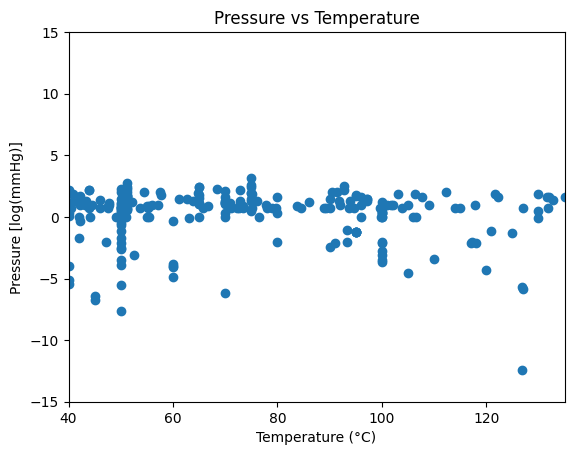

Number of datapoints with temperature from 40 to 135 ºC: 242
Number of datapoints: 230
Number of organic compounds in temperature interval: 170
CC(CNCC(C)O)O 42.0 -1.6983915750504084
CC1=CC=C(C=C1)N 42.0 -0.010959484108146695
CCCCCCCCC=CCCCCCCCC(=O)O.C(CO)NCCO 42.22 1.08278537031645
C(C(=O)O)NCP(=O)(O)O 45.0 -6.7121982700697735
COC1=CC=CC(=C1)N 46.11 1.3384564936046048
CCOC1=CC=C(C=C1)N 50.0 -1.7099294884441656
C(CCCN)CCN 50.0 -0.4814860601221125
C(CCCN)CCN 50.0 0.15385076453784546
C1=CC=C(C(=C1)C(=O)O)N 52.22 1.2041199826559248
CN(C)CCC#N 55.5 -0.0010511954478976794
CCCCCCCCC=CCCCCCCCC(=O)O.C(CO)NCCO 65.0 1.0492180226701815
C1=CC=C(C(=C1)N)Cl 71.0 1.1430148002540952
CC1=C(C(=CC=C1)C)N 71.11 0.705007959333336
CC1=CC(=C(C=C1)N)C 78.0 0.6989700043360189
CCN(CC)CCSP(=O)(OCC)OCC 78.89 0.6989700043360189
CN(C)C#N 80.0 -2.0
CC(C)NC1=CC=C(C=C1)NC2=CC=CC=C2 88.89 0.6989700043360189
CCOC1=CC=CC(=C1)N 93.33 -2.0
CC1=CC(=C(C=C1)C)N 95.0 1.6812412373755872
C1=CC(=CC(=C1)N)N 97.22 1.414973347970818

In [ ]:
from collections import Counter
# Read the Excel file and create a DataFrame
df_2 = pd.read_excel('pubchem_pressures.xlsx')

T = []
P = []
canonical_smiles = []

for index, row in df_2.iterrows():
    for col in df_2.columns:
        if col.startswith("Pressure"):
            value = row[col]
            if pd.notnull(value):
                # Extract the temperature and pressure values from the string
                temperature = value[value.find("(")+1:value.find(")")]
                pressure = value[value.find("=")+1:]

                # If the pressure is -inf or inf, we want to skip this value
                if pressure == "-inf" or pressure == "inf":
                    continue
                else: 
                    temperature = float(temperature)
                    if 40 <= temperature <= 135:
                        T.append(temperature)
                        P.append(float(pressure))
                        canonical_smiles.append(row['SMILES'])

# Want to sort the temperature, pressure values and canonical smiles in ascending order of temperature
T, P, canonical_smiles = zip(*sorted(zip(T, P, canonical_smiles)))

T = list(T)
P = list(P)
canonical_smiles = list(canonical_smiles)

# Plot the pressure as a function of temperature
plt.scatter(T, P)
plt.xlabel('Temperature (°C)')
plt.ylabel('Pressure [log(mmHg)]')
plt.title('Pressure vs Temperature')
plt.xlim(40, 135)
plt.ylim(-15, 15)
plt.show()

print(f"Number of datapoints with temperature from 40 to 135 ºC: {len(T)}")


# Iterate over the SMILES and remove the ones without "C". Important that the sumbol that comes after this "C" is not 
# in lower case, as this would indicate that it is Cl atom or something else.
for i in range(len(canonical_smiles)):
    if "C" not in canonical_smiles[i]:
        canonical_smiles[i] = None
        T[i] = None
        P[i] = None
    else:
        index = canonical_smiles[i].index("C")
        if canonical_smiles[i][index+1].islower():
            canonical_smiles[i] = None

# Remove all the None values from the list.
T = [x for x in T if x is not None]
P = [x for x in P if x is not None]
canonical_smiles = [x for x in canonical_smiles if x is not None]

print(f"Number of datapoints: {len(T)}")
unique_elements = len(set(canonical_smiles))
print(f"Number of organic compounds in temperature interval: {unique_elements}")

# Want to figure out how many amines are present in the dataset
amines = []
for index, smiles in enumerate(canonical_smiles):
    amine = check_if_amine(smiles)
    if amine:
        amines.append(smiles)
        print(smiles, T[index], P[index])

print(f"Number of amines: {len(amines)}")
